# Multilevel/Hierarchical regression with Python: `bambi`, `pymc`, `arviz`, `loo`, and `preliz`

This workshop's goal—which is facilitated by this notebook—is to give attendees the confidence to conduct Bayesian regression analyses with `Python` for their research projects.

[`bambi`](https://bambinos.github.io/bambi/) is a high-level Bayesian model-building interface written in `Python`.

[`pymc`](https://www.pymc.io/welcome.html) allows you to write down Bayesian models using an intuitive syntax to describe a data generating process.

[`arviz`](https://python.arviz.org/en/stable/index.html) is a `Python` package for exploratory analysis of Bayesian models.

[`loo`](https://mc-stan.org/loo/index.html) allows users to compute efficient approximate leave-one-out cross-validation for fitted Bayesian models, as well as model weights that can be used to average predictive distributions.

[`preliz`](https://preliz.readthedocs.io/en/latest/index.html) helps practitioners choose prior distributions by offering a set of tools for the various facets of prior elicitation. 

To motivate this workshop, we'll work with examples from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html) and go through the various steps of conducting regression analyses in a [Bayesian workflow](https://arxiv.org/abs/2011.01808). Hopefully, you will come away feeling confident you can use `Python` to conduct regression analyses for your research projects.

# Table of Contents

## Multilevel/Hierarchical regression with [`bambi`](https://bambinos.github.io/bambi/)

### **Without** predictors

- ### Complete pooling

- ### No pooling

- ### Partial pooling (Multilevel/Hierarchical)

### **With** predictors

- ### Complete pooling

- ### No pooling

- ### Partial pooling (Multilevel/Hierarchical)

- ### Model comparison

---

## Load packages

In [ ]:
%pip install arviz==0.22.0 bambi==0.16.0 preliz==0.22.0 pymc==5.26.1 --quiet

In [2]:
import logging

def silence_pytensor_warnings():
    """
    Suppress harmless PyTensor 'rewrite failure' and traceback messages
    that appear when building or graphing PyMC/Bambi models.
    Safe to call once per session or notebook.
    """
    
    class _SuppressPyTensorRewrite(logging.Filter):
        def filter(self, record):
            msg = record.getMessage()
            blocked_phrases = [
                "Rewrite failure due to:",
                "random_make_inplace",
                "Tensor type field must be a TensorType",
                "ERROR (pytensor.graph.rewriting.basic): node:",
                "ERROR (pytensor.graph.rewriting.basic): TRACEBACK",
                "TRACEBACK:",
                "RandomGeneratorType",
                "NoneTypeT"
            ]
            return not any(phrase in msg for phrase in blocked_phrases)

    for name in [
        "pytensor",
        "pytensor.graph.rewriting.basic",
        "pytensor.compile",
        "pytensor.tensor"
    ]:
        logger = logging.getLogger(name)
        logger.addFilter(_SuppressPyTensorRewrite())
        logger.setLevel(logging.ERROR)

    # Silence related packages
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("bambi").setLevel(logging.ERROR)

    print("✅ PyTensor rewrite and traceback warnings silenced.")

In [3]:
from datetime import datetime

import random
import numpy as np
from numpy.random import default_rng
from numpy.polynomial.polynomial import polyfit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.special import expit, logit
from scipy.interpolate import interp1d, make_interp_spline, BSpline
import pandas as pd
from pandas.api.types import CategoricalDtype
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import pymc as pm
import bambi as bmb
import arviz as az
import preliz as pz

from IPython.display import HTML
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pytensor")

print(f"Arviz: {az.__version__}")
print(f"Bambi: {bmb.__version__}")
print(f"Preliz: {pz.__version__}")
print(f"PyMC: {pm.__version__}")
md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Arviz: 0.22.0
Bambi: 0.16.0
Preliz: 0.22.0
PyMC: 5.26.1


Analysis last performed on 10/26/2025.

In [4]:
silence_pytensor_warnings()  # Call once per notebook/session

✅ PyTensor rewrite and traceback warnings silenced.


In [5]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

In [6]:
xr.set_options(display_expand_data=False, display_expand_attrs=False);

`display_expand_data=False` makes the default view for `xarray.DataArray` fold the data values to a single line. To explore the values, click on the DB icon on the left of the view, right under the `xarray.DataArray` text. It has no effect on `Dataset` objects that already default to folded views.

`display_expand_attrs=False` folds the attributes in both `DataArray` and `Dataset` objects to keep the views shorter. In this notebook we print `DataArrays` and `Datasets` several times, so let's fold the data values to a single line.

## List pre-defined style sheets provided by matplotlib:

In [7]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-doc',
 'arviz-docgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'preliz-doc',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Visualization in Bayesian workflow
- ### Plot data
- ### Plot model
- ### Plot prior parameter distributions
- ### Plot prior predictive distribution
- ### Plot MCMC diagnostics
- ### Plot posterior parameter distributions
- ### Plot posterior predictive distribution
- ### Plot model comparisons

## Load Data into DataFrame

The data used in these examples is available in the following [GitHub repository](https://github.com/stan-dev/rstanarm/). For this example, we're working with the `radon` dataset from [Data Analysis Using Regression and Multilevel/Hierarchical Models](https://sites.stat.columbia.edu/gelman/arm/).

In [8]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Load data into a DataFrame
radon = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2025ODSCWest/refs/heads/main/data/radon.csv')
radon.round(1)

idnum state state2  stfips    zip  region  typebldg     floor  room  \
0     5540    MN     MN      27  56031       5         1  Basement     4   
1     5665    MN     MN      27  55110       3         1  Basement     4   
2     5666    MN     MN      27  55112       3         1  Basement     4   
3     5667    MN     MN      27  55112       3         1  Basement     2   
4     5668    MN     MN      27  55113       3         1  Basement     2   
..     ...   ...    ...     ...    ...     ...       ...       ...   ...   
914   5757    MN     MN      27  55731       1         1     Floor     3   
915   5759    MN     MN      27  55732       1         1     Floor     1   
916   5765    MN     MN      27  55741       1         1     Floor     3   
917   5718    MN     MN      27  55044       5         1     Floor     1   
918   5081    MN     MN      27  55735       5         1     Floor     3   

    basement  ... pcterr   adjwt  dupflag  zipflag  cntyfips    county   fips  \
0          Y  ...    5.6  1177.4        0        0        91    MARTIN  27091   
1          Y  ...   11.0  2314.4        0        0       123    RAMSEY  27123   
2          Y  ...   16.7  2116.6        0        0       123    RAMSEY  27123   
3          Y  ...    6.5  2116.6        0        0       123    RAMSEY  27123   
4          Y  ...    5.3  2179.5        0        0       123    RAMSEY  27123   
..       ...  ...    ...     ...      ...      ...       ...       ...    ...   
914        Y  ...   29.7   461.3        0        0       137  ST LOUIS  27137   
915        Y  ...   11.3   461.3        0        0       137  ST LOUIS  27137   
916        Y  ...   35.3   461.6        0        0       137  ST LOUIS  27137   
917        N  ...    3.7   461.3        0        0       139     SCOTT  27139   
918        N  ...    9.7  1146.5        1        0         1    AITKIN  27001   

     Uppm  log_radon  log_u  
0     1.2        1.4    0.2  
1     0.7        1.0   -0.4  
2     0.7        0.3   -0.4  
3     0.7        1.3   -0.4  
4     0.7        1.7   -0.4  
..    ...        ...    ...  
914   0.6       -0.5   -0.5  
915   0.6        0.5   -0.5  
916   0.6        0.0   -0.5  
917   1.1        2.2    0.1  
918   0.5        0.8   -0.7  

[919 rows x 29 columns]

## Explore Data

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

# Check for missing values
radon.isna().sum()

idnum        0
state        0
state2       0
stfips       0
zip          0
region       0
typebldg     0
floor        0
room         0
basement     0
windoor      0
rep          0
stratum      0
wave         0
starttm      0
stoptm       0
startdt      0
stopdt       0
activity     0
pcterr       0
adjwt        0
dupflag      0
zipflag      0
cntyfips     0
county       0
fips         0
Uppm         0
log_radon    0
log_u        0
dtype: int64

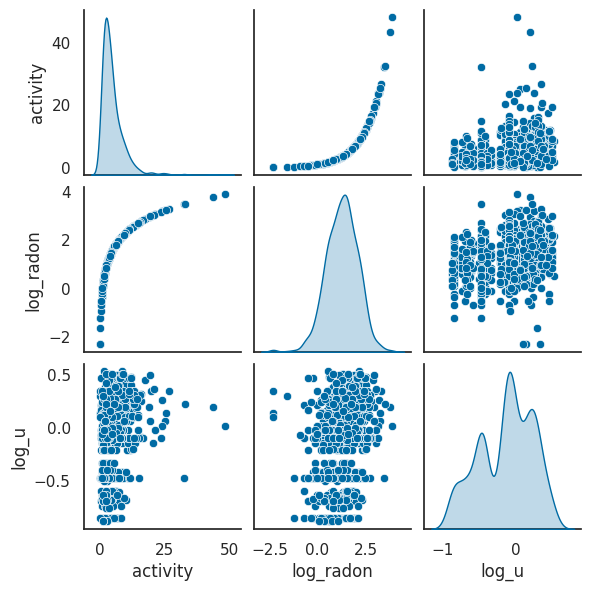

In [ ]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Review the joint distribution of the variables in the dataset
sns.pairplot(radon[['activity', 'log_radon', 'log_u']], diag_kind='kde', height=2, aspect=1);

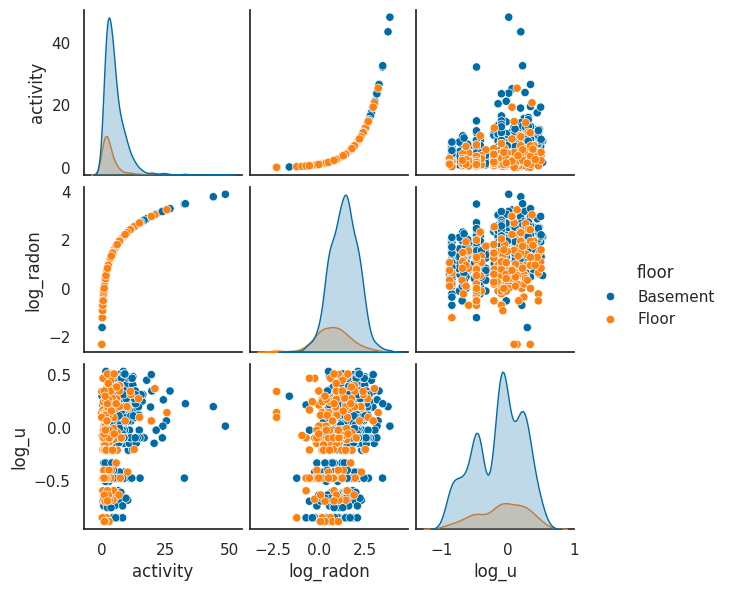

In [ ]:
sns.pairplot(radon[['activity', 'log_radon', 'log_u', 'floor']], hue='floor', diag_kind='kde', height=2, aspect=1);

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# Review the summary statistics for the variables in the dataset
radon.describe().round(decimals=1)  # transpose().round(decimals=1)

idnum  stfips      zip  region  typebldg   room    rep  stratum  \
count   919.0   919.0    919.0   919.0     919.0  919.0  919.0    919.0   
mean   5540.0    27.0  55729.6     3.1       1.0    3.3    2.9      3.2   
std     265.4     0.0    516.8     1.3       0.5    1.6    1.4      1.1   
min    5081.0    27.0  55007.0     1.0       0.0    0.0    1.0      1.0   
25%    5310.5    27.0  55318.0     2.0       1.0    2.0    2.0      2.0   
50%    5540.0    27.0  55746.0     3.0       1.0    4.0    3.0      3.0   
75%    5769.5    27.0  56119.5     4.0       1.0    4.0    4.0      4.0   
max    5999.0    27.0  57006.0     5.0       5.0    7.0    5.0      5.0   

        wave  starttm  ...  activity  pcterr   adjwt  dupflag  zipflag  \
count  919.0    919.0  ...     919.0   919.0   919.0    919.0    919.0   
mean    32.0   1413.8  ...       4.8    10.5  1051.7      0.1      0.0   
std     13.0    483.3  ...       4.5     8.5   595.8      0.3      0.0   
min      1.0      0.0  ...       0.0     0.0   348.0      0.0      0.0   
25%     25.0   1000.0  ...       1.9     5.2   471.4      0.0      0.0   
50%     34.0   1415.0  ...       3.6     8.1   990.4      0.0      0.0   
75%     42.0   1817.5  ...       6.0    12.7  1146.5      0.0      0.0   
max     50.0   2337.0  ...      48.2    66.3  2314.4      2.0      1.0   

       cntyfips     fips   Uppm  log_radon  log_u  
count     919.0    919.0  919.0      919.0  919.0  
mean       87.4  27087.4    0.9        1.3   -0.1  
std        52.1     52.1    0.3        0.8    0.4  
min         1.0  27001.0    0.4       -2.3   -0.9  
25%        41.0  27041.0    0.6        0.7   -0.5  
50%        85.0  27085.0    0.9        1.3   -0.1  
75%       137.0  27137.0    1.2        1.8    0.2  
max       173.0  27173.0    1.7        3.9    0.5  

[8 rows x 23 columns]

In [ ]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.describe.html

# Review the summary statistics for the variables in the dataset
statsmodels.stats.descriptivestats.describe(radon).round(2)

idnum  stfips       zip  region   typebldg    room  \
nobs               919.00   919.0    919.00  919.00     919.00  919.00   
missing              0.00     0.0      0.00    0.00       0.00    0.00   
mean              5540.00    27.0  55729.58    3.12       1.04    3.29   
std_err              8.76     0.0     17.05    0.04       0.01    0.05   
upper_ci          5557.16    27.0  55762.99    3.20       1.07    3.39   
lower_ci          5522.84    27.0  55696.17    3.04       1.01    3.18   
std                265.44     0.0    516.79    1.30       0.45    1.62   
iqr                459.00     0.0    801.50    2.00       0.00    2.00   
iqr_normal         340.26     0.0    594.15    1.48       0.00    1.48   
mad                229.75     0.0    442.19    1.05       0.13    1.27   
mad_normal         287.95     0.0    554.21    1.32       0.17    1.59   
coef_var             0.05     0.0      0.01    0.42       0.44    0.49   
range              918.00     0.0   1999.00    4.00       5.00    7.00   
max               5999.00    27.0  57006.00    5.00       5.00    7.00   
min               5081.00    27.0  55007.00    1.00       0.00    0.00   
skew                 0.00     NaN      0.27   -0.04       5.92    0.20   
kurtosis             1.80     NaN      1.95    2.00      53.05    3.45   
jarque_bera         55.14     NaN     53.54   38.82  101282.09   14.02   
jarque_bera_pval     0.00     NaN      0.00    0.00       0.00    0.00   
mode              5081.00    27.0  55075.00    3.00       1.00    4.00   
mode_freq            0.00     1.0      0.02    0.32       0.93    0.46   
median            5540.00    27.0  55746.00    3.00       1.00    4.00   
1%                5090.18    27.0  55014.00    1.00       0.00    0.00   
5%                5126.90    27.0  55032.90    1.00       1.00    0.00   
10%               5172.80    27.0  55060.00    1.00       1.00    1.00   
25%               5310.50    27.0  55318.00    2.00       1.00    2.00   
50%               5540.00    27.0  55746.00    3.00       1.00    4.00   
75%               5769.50    27.0  56119.50    4.00       1.00    4.00   
90%               5907.20    27.0  56481.20    5.00       1.00    4.00   
95%               5953.10    27.0  56633.00    5.00       1.00    7.00   
99%               5989.82    27.0  56756.82    5.00       2.82    7.00   

                     rep  stratum    wave  starttm  ...  activity   pcterr  \
nobs              919.00   919.00  919.00   919.00  ...    919.00   919.00   
missing             0.00     0.00    0.00     0.00  ...      0.00     0.00   
mean                2.94     3.17   32.01  1413.82  ...      4.77    10.48   
std_err             0.05     0.04    0.43    15.94  ...      0.15     0.28   
upper_ci            3.03     3.24   32.85  1445.07  ...      5.06    11.03   
lower_ci            2.85     3.10   31.17  1382.58  ...      4.48     9.93   
std                 1.42     1.13   13.01   483.27  ...      4.48     8.48   
iqr                 2.00     2.00   17.00   817.50  ...      4.10     7.50   
iqr_normal          1.48     1.48   12.60   606.01  ...      3.04     5.56   
mad                 1.22     0.94   10.20   423.48  ...      2.96     5.72   
mad_normal          1.53     1.17   12.78   530.75  ...      3.71     7.17   
coef_var            0.48     0.36    0.41     0.34  ...      0.94     0.81   
range               4.00     4.00   49.00  2337.00  ...     48.20    66.30   
max                 5.00     5.00   50.00  2337.00  ...     48.20    66.30   
min                 1.00     1.00    1.00     0.00  ...      0.00     0.00   
skew                0.07     0.28   -0.88    -0.02  ...      3.41     2.66   
kurtosis            1.69     2.03    3.28     1.88  ...     23.50    13.51   
jarque_bera        66.60    47.96  122.25    47.70  ...  17877.79  5312.44   
jarque_bera_pval    0.00     0.00    0.00     0.00  ...      0.00     0.00   
mode                2.00     3.00   22.00   800.00  ...      1.80     0.00   
mode_freq    

---

## **Complete pooling** without predictors

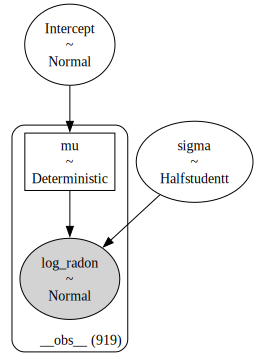

In [9]:
pooled_model = bmb.Model("log_radon ~ 1", data=radon)

pooled_model.build()

pooled_model.graph()

## Plot prior parameter distributions

[Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

1. Flat prior (not usually recommended).

2. Super-vague but proper prior: normal(0, 1e6) (not usually recommended).

3. Weakly informative prior, very weak: normal(0, 10).

4. Generic weakly informative prior: normal(0, 1).

5. Specific informative prior: normal(0.4, 0.2) or whatever. Sometimes this can be expressed as a scaling followed by a generic prior: theta = 0.4 + 0.2*z ; z ~ normal(0, 1).

The above numbers assume that parameters are roughly on unit scale, as is done in education (where 0 is average test score in some standard population (e.g., all students at a certain grade level) and 1 is sd of test scores in that population) or medicine (where 0 is zero dose and 1 is a standard dose such as 10mcg/day of cyanocobalamin, 1,000 IU/day cholecalciferol, etc.; these examples come from Sander Greenland).

In addition, statements such as "informative" or "weakly informative" depend crucially on what questions are being asked (a point that is related to the idea that [the prior can often only be understood in the context of the likelihood](http://www.stat.columbia.edu/~gelman/research/published/entropy-19-00555-v2.pdf)).

[Default (Weakly Informative) Prior Distributions](https://mc-stan.org/rstanarm/articles/priors.html)

With very few exceptions, the default priors in [`rstanarm`](https://mc-stan.org/rstanarm/articles/priors.html) —the priors used if they aren't specified— are not flat priors. Rather, the defaults are intended to be weakly informative. That is, they are designed to provide moderate regularization and help stabilize computation. For many (if not most) applications the defaults will perform well, but this is not guaranteed (there are no default priors that make sense for every possible model specification).

[Prior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model - in short, they help you check how credible your assumptions before seeing the data are.

* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

[`Model.plot_priors`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors): Samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors) distribution and plots its marginals.

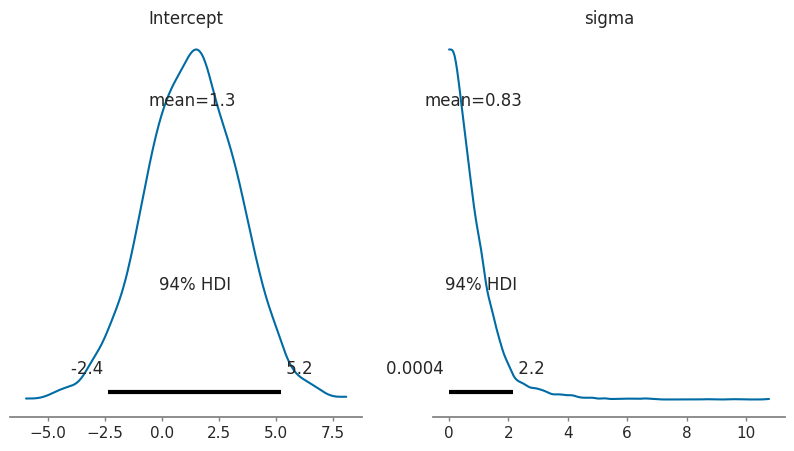

In [ ]:
pooled_model.plot_priors(figsize=(10,5));

## Fit model

[Fit](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit) the model using PyMC.

`draws`: The number of samples to draw from the posterior distribution. Defaults to `1000`.

`tune`: Number of iterations to tune. Defaults to `1000`.

`chains`: The number of chains to sample. Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior. If `None` (default), then set to either `cores` or `2`, whichever is larger.

`inference_method`: The method to use for fitting the model. By default, [`"mcmc"`](https://www.bayesrulesbook.com/chapter-7). This automatically assigns a [MCMC](https://mc-stan.org/docs/reference-manual/hmc.html) method best suited for each kind of variables, like [NUTS](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html) for continuous variables and [Metropolis](https://mc-stan.org/docs/reference-manual/hmc.html) for non-binary discrete ones. Alternatively, `"vi"`, in which case the model will be fitted using [variational inference](https://mc-stan.org/docs/reference-manual/vi-algorithms.html) as implemented in PyMC using the `fit` function.

[Markov Chain Monte Carlo (MCMC)](https://bookdown.org/content/4857/markov-chain-monte-carlo.html): This chapter introduces one commonplace example of [Fortuna](https://en.wikipedia.org/wiki/Rota_Fortunae#/media/File:Lydgate-siege-troy-wheel-fortune-detail.jpg) and [Minerva](https://en.wikipedia.org/wiki/Minerva#/media/File:Minerva-Vedder-Highsmith-detail-1.jpeg)'s cooperation: the estimation of posterior probability distributions using a stochastic process known as **Markov chain Monte Carlo (MCMC)** ([McElreath, 2020a, p. 263](https://bookdown.org/content/4857/markov-chain-monte-carlo.html#ref-mcelreathStatisticalRethinkingBayesian2020), **emphasis** in the original).

[Model log-likelihood](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood)

In order to compute [`LOO`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) and [`WAIC`](https://python.arviz.org/en/stable/api/generated/arviz.waic.html), [`ArviZ`](https://python.arviz.org/en/stable/index.html) needs access to the model elemwise loglikelihood for every posterior sample. We can pass `idata_kwargs={"log_likelihood": True}` to have it computed automatically at the end of sampling.

In [10]:
pooled_results = pooled_model.fit(idata_kwargs=dict(log_likelihood=True))

pooled_results

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

[Introduction to xarray, InferenceData, and netCDF for ArviZ](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html)

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) generates numerous datasets that represent different aspects of the model. For example, in a single analysis, a Bayesian practitioner could end up with any of the following data.

* Prior Distribution for N number of variables

* Posterior Distribution for N number of variables

* Prior Predictive Distribution

* Posterior Predictive Distribution

* Trace data for each of the above

* Sample statistics for each inference run

* Any other array like data source

[`InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html#additional-reading)

* [Working with `InferenceData`](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#working-with-inferencedata): Tutorial covering the most common operations with `InferenceData` objects

* [Creating `InferenceData`](https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#creating-inferencedata): Cookbook with examples of generating `InferenceData` objects from multiple sources, both external inference libraries like

* [data module API reference](https://python.arviz.org/en/stable/api/data.html#data-api)

* [`InferenceData` API reference](https://python.arviz.org/en/stable/api/inference_data.html#idata-api): description of all available `InferenceData` methods, grouped by topic

[`InferenceData` schema specification](https://python.arviz.org/en/stable/schema/schema.html)

* [Terminology](https://python.arviz.org/en/stable/schema/schema.html#terminology)

* [Rules](https://python.arviz.org/en/stable/schema/schema.html#rules)

* [Metadata](https://python.arviz.org/en/stable/schema/schema.html#metadata)

* [Relations between groups](https://python.arviz.org/en/stable/schema/schema.html#relations-between-groups)

* [Example of schema](https://python.arviz.org/en/stable/schema/PyMC3_schema_example.html)

## Plot MCMC diagnostics

[`az.ess`](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): Calculate estimate of the effective sample size (`ess`). The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. The 𝑛𝑒𝑓𝑓 metric used in Stan is based on the ability of the draws to estimate the true mean value of the parameter, which is related to (but not necessarily equivalent to) estimating other functions of the draws. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, 𝑛𝑒𝑓𝑓, is usually smaller than the total sample size, 𝑁 (although it may be larger in some cases1). The larger the ratio of 𝑛𝑒𝑓𝑓 to 𝑁 the better (see Gelman et al. 2013, Stan Development Team 2018 for more details).

[`az.rhat`](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): Compute estimate of rank normalized splitR-hat for a set of traces.  The rank normalized [`R-hat`](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic) diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain.  If convergence has been achieved, the between-chain and within-chain variances should be identical.  To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.


[`az.mcse`](https://python.arviz.org/en/stable/api/generated/arviz.mcse.html): Calculate Markov Chain Standard Error (`mcse`) statistic.  The [Monte Carlo standard error](https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html) is the uncertainty about a statistic in the sample due to sampling error. With a independent sample of size N, the MCSE for the sample mean is MCSE(θbar) = s / √N , where s is the sample standard deviation.
However, MCMC are generally not independent, and the MCSE will be higher than that of an independent sample. One way to calculate the MCSE with autocorrelated samples is to use the effective sample size instead of the sample size, MCSE(θbar) = s / √Neff.

[`az.plot_trace`](https://python.arviz.org/en/stable/examples/plot_trace.html) distribution (histogram or kernel density estimates) and sampled values or rank plot.  If `divergences` data is available in `sample_stats`, will plot the location of divergences as dashed vertical lines.

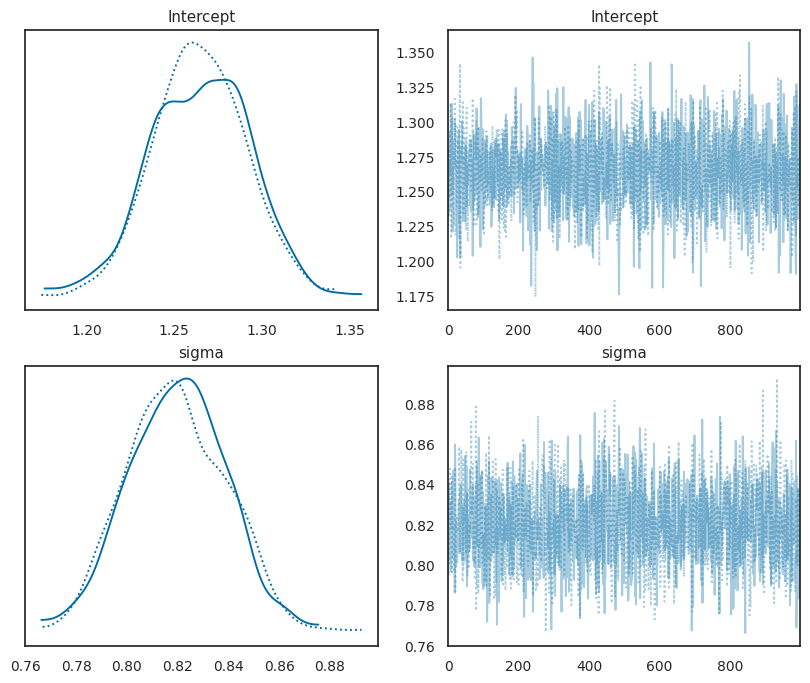

In [ ]:
az.plot_trace(pooled_results, figsize=(10,8));

## Plot posterior distributions

The [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) is a type of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) that results from [updating](https://en.wikipedia.org/wiki/Bayesian_updating) the [prior probability](https://en.wikipedia.org/wiki/Prior_probability) with information summarized by the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) via an application of [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_rule).

Chapter 7 [The Posterior - The Goal of Bayesian
Inference](https://sites.math.rutgers.edu/~zeilberg/EM20/Lambert.pdf) in "A Student's Guide to Bayesian Statistics" by Ben Lambert

[`az.plot_posterior`](https://python.arviz.org/en/stable/examples/plot_posterior.html): Plot Posterior densities in the style of John K. Kruschke's [book](https://sites.google.com/site/doingbayesiandataanalysis/).

[`az.plot_pair`](https://python.arviz.org/en/stable/examples/plot_pair.html): Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

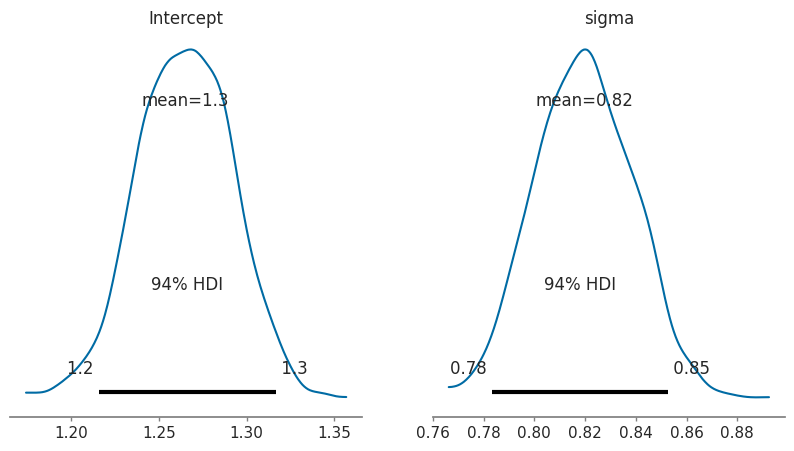

In [ ]:
az.plot_posterior(pooled_results, figsize=(10,5));

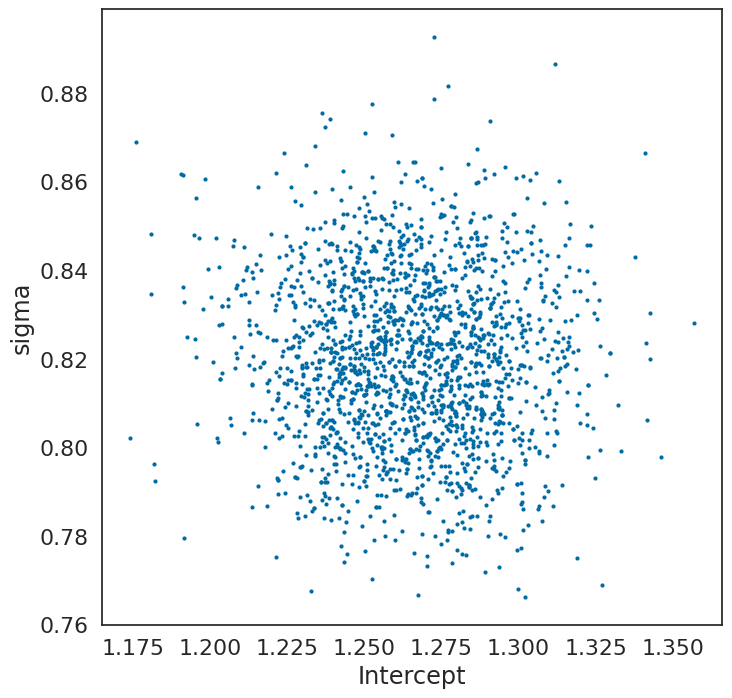

In [ ]:
az.plot_pair(pooled_results, figsize=(8,8));

[`az.summary`](https://python.arviz.org/en/stable/api/generated/arviz.summary.html): Create a data frame with summary statistics.

In [ ]:
az.summary(pooled_results).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  1.26  0.03    1.22     1.32        0.0      0.0    1983.0   
sigma      0.82  0.02    0.78     0.85        0.0      0.0    1816.0   

           ess_tail  r_hat  
Intercept    1537.0    1.0  
sigma        1641.0    1.0

In [11]:
pooled_results_df = az.extract(pooled_results).to_dataframe()[['Intercept', 'sigma']]
pooled_results_df.round(2)

Intercept  sigma
chain draw                  
0     0          1.29   0.82
      1          1.24   0.82
      2          1.26   0.86
      3          1.27   0.79
      4          1.27   0.83
...               ...    ...
3     995        1.31   0.83
      996        1.29   0.83
      997        1.27   0.80
      998        1.27   0.80
      999        1.28   0.83

[4000 rows x 2 columns]

In [ ]:
pooled_results_df.describe().T.round(2)

count  mean   std   min   25%   50%   75%   max
Intercept  2000.0  1.26  0.03  1.17  1.25  1.27  1.28  1.36
sigma      2000.0  0.82  0.02  0.77  0.81  0.82  0.83  0.89

In [ ]:
pooled_results_df.cov()

Intercept     sigma
Intercept   0.000733 -0.000018
sigma      -0.000018  0.000371

In [ ]:
pooled_results.posterior["Intercept"][0][:10] # .to_pandas() or .to_series()

<xarray.DataArray 'Intercept' (draw: 10)> Size: 80B
array([1.24340938, 1.23255162, 1.24808648, 1.28281341, 1.23628845,
       1.29323229, 1.25366548, 1.25366548, 1.2469554 , 1.26321452])
Coordinates:
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
    chain    int64 8B 0

## Plot posterior predictive distributions

[Posterior predictive checks (PPCs)](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism.

[Graphical posterior predictive checks (PPCs)](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html)

The `bayesplot` package provides various plotting functions for graphical posterior predictive checking, that is, creating graphical displays comparing observed data to simulated data from the posterior predictive distribution ([Gabry et al, 2019](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html#gabry2019)).

The idea behind [posterior predictive checking](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) is simple: if a model is a good fit then we should be able to use it to generate data that looks a lot like the data we observed. To generate the data used for posterior predictive checks (PPCs) we simulate from the posterior predictive distribution. This is the distribution of the outcome variable implied by a model after using the observed data 𝑦 (a vector of 𝑁 outcome values) to update our beliefs about unknown model parameters 𝜃.

[Predict method for Bambi models](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)

Obtains in-sample and out-of-sample predictions from a fitted Bambi model.

`kind` indicates the type of prediction required. Can be `"response_params"` or `"response"`. The first returns draws from the posterior distribution of the likelihood parameters, while the latter returns the draws from the posterior predictive distribution (i.e. the posterior probability distribution for a new observation) in addition to the posterior distribution. Defaults to `"response_params"`.

In [12]:
posterior_predictive = pooled_model.predict(pooled_results, kind="response")
pooled_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

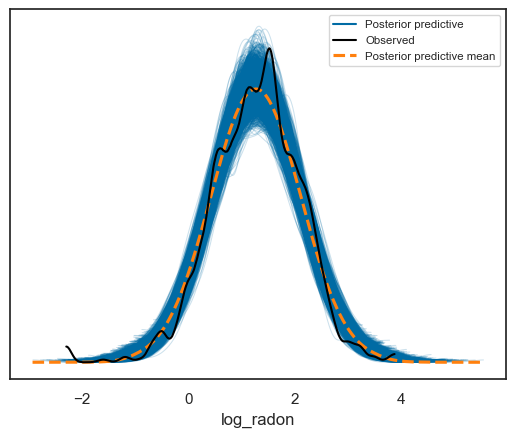

In [13]:
az.plot_ppc(pooled_results);

[loo](https://mc-stan.org/loo/index.html): Efficient approximate leave-one-out cross-validation for fitted Bayesian models

From existing posterior simulation draws, we compute approximate `LOO-CV` using Pareto smoothed importance sampling (`PSIS`), a new procedure for regularizing importance weights. As a byproduct of our calculations, we also obtain approximate standard errors for estimated predictive errors and for comparing predictive errors between two models. We recommend `PSIS-LOO-CV` instead of `WAIC`, because `PSIS` provides useful diagnostics and effective sample size and Monte Carlo standard error estimates.

[`az.loo`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html): Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

In [14]:
loo_pooled = az.loo(pooled_results)
loo_pooled

Computed from 4000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1122.70    25.90
p_loo        2.52        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      919  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

[LOO package glossary](https://mc-stan.org/loo/reference/loo-glossary.html)

`elpd`: approximated expected log pointwise predictive density (elpd).

`se`: standard error of the elpd.

`p_loo`: effective number of parameters. If we have a well-specified model, we expect the estimated effective number of parameters (`p_loo`) to be smaller than or similar to the total number of parameters in the model.

Pareto 𝑘 diagnostic values are used to assess the reliability of the estimates. In addition to the proportion of leave-one-out folds with 𝑘 values in different intervals, the minimum of the effective sample sizes in that category is shown to give idea why higher 𝑘 values are bad.

---

## **No pooling** without predictors

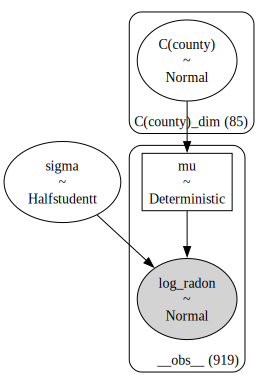

In [20]:
# Fit unpooled model: separate intercept for each county
unpooled_model = bmb.Model("log_radon ~ 0 + C(county)", data=radon)

unpooled_model.build()

unpooled_model.graph()

## Plot prior parameter distributions

[Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

1. Flat prior (not usually recommended).

2. Super-vague but proper prior: normal(0, 1e6) (not usually recommended).

3. Weakly informative prior, very weak: normal(0, 10).

4. Generic weakly informative prior: normal(0, 1).

5. Specific informative prior: normal(0.4, 0.2) or whatever. Sometimes this can be expressed as a scaling followed by a generic prior: theta = 0.4 + 0.2*z ; z ~ normal(0, 1).

The above numbers assume that parameters are roughly on unit scale, as is done in education (where 0 is average test score in some standard population (e.g., all students at a certain grade level) and 1 is sd of test scores in that population) or medicine (where 0 is zero dose and 1 is a standard dose such as 10mcg/day of cyanocobalamin, 1,000 IU/day cholecalciferol, etc.; these examples come from Sander Greenland).

In addition, statements such as "informative" or "weakly informative" depend crucially on what questions are being asked (a point that is related to the idea that [the prior can often only be understood in the context of the likelihood](http://www.stat.columbia.edu/~gelman/research/published/entropy-19-00555-v2.pdf)).

[Default (Weakly Informative) Prior Distributions](https://mc-stan.org/rstanarm/articles/priors.html)

With very few exceptions, the default priors in [`rstanarm`](https://mc-stan.org/rstanarm/articles/priors.html) —the priors used if they aren't specified— are not flat priors. Rather, the defaults are intended to be weakly informative. That is, they are designed to provide moderate regularization and help stabilize computation. For many (if not most) applications the defaults will perform well, but this is not guaranteed (there are no default priors that make sense for every possible model specification).

[Prior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model - in short, they help you check how credible your assumptions before seeing the data are.

* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

[`Model.plot_priors`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors): Samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors) distribution and plots its marginals.

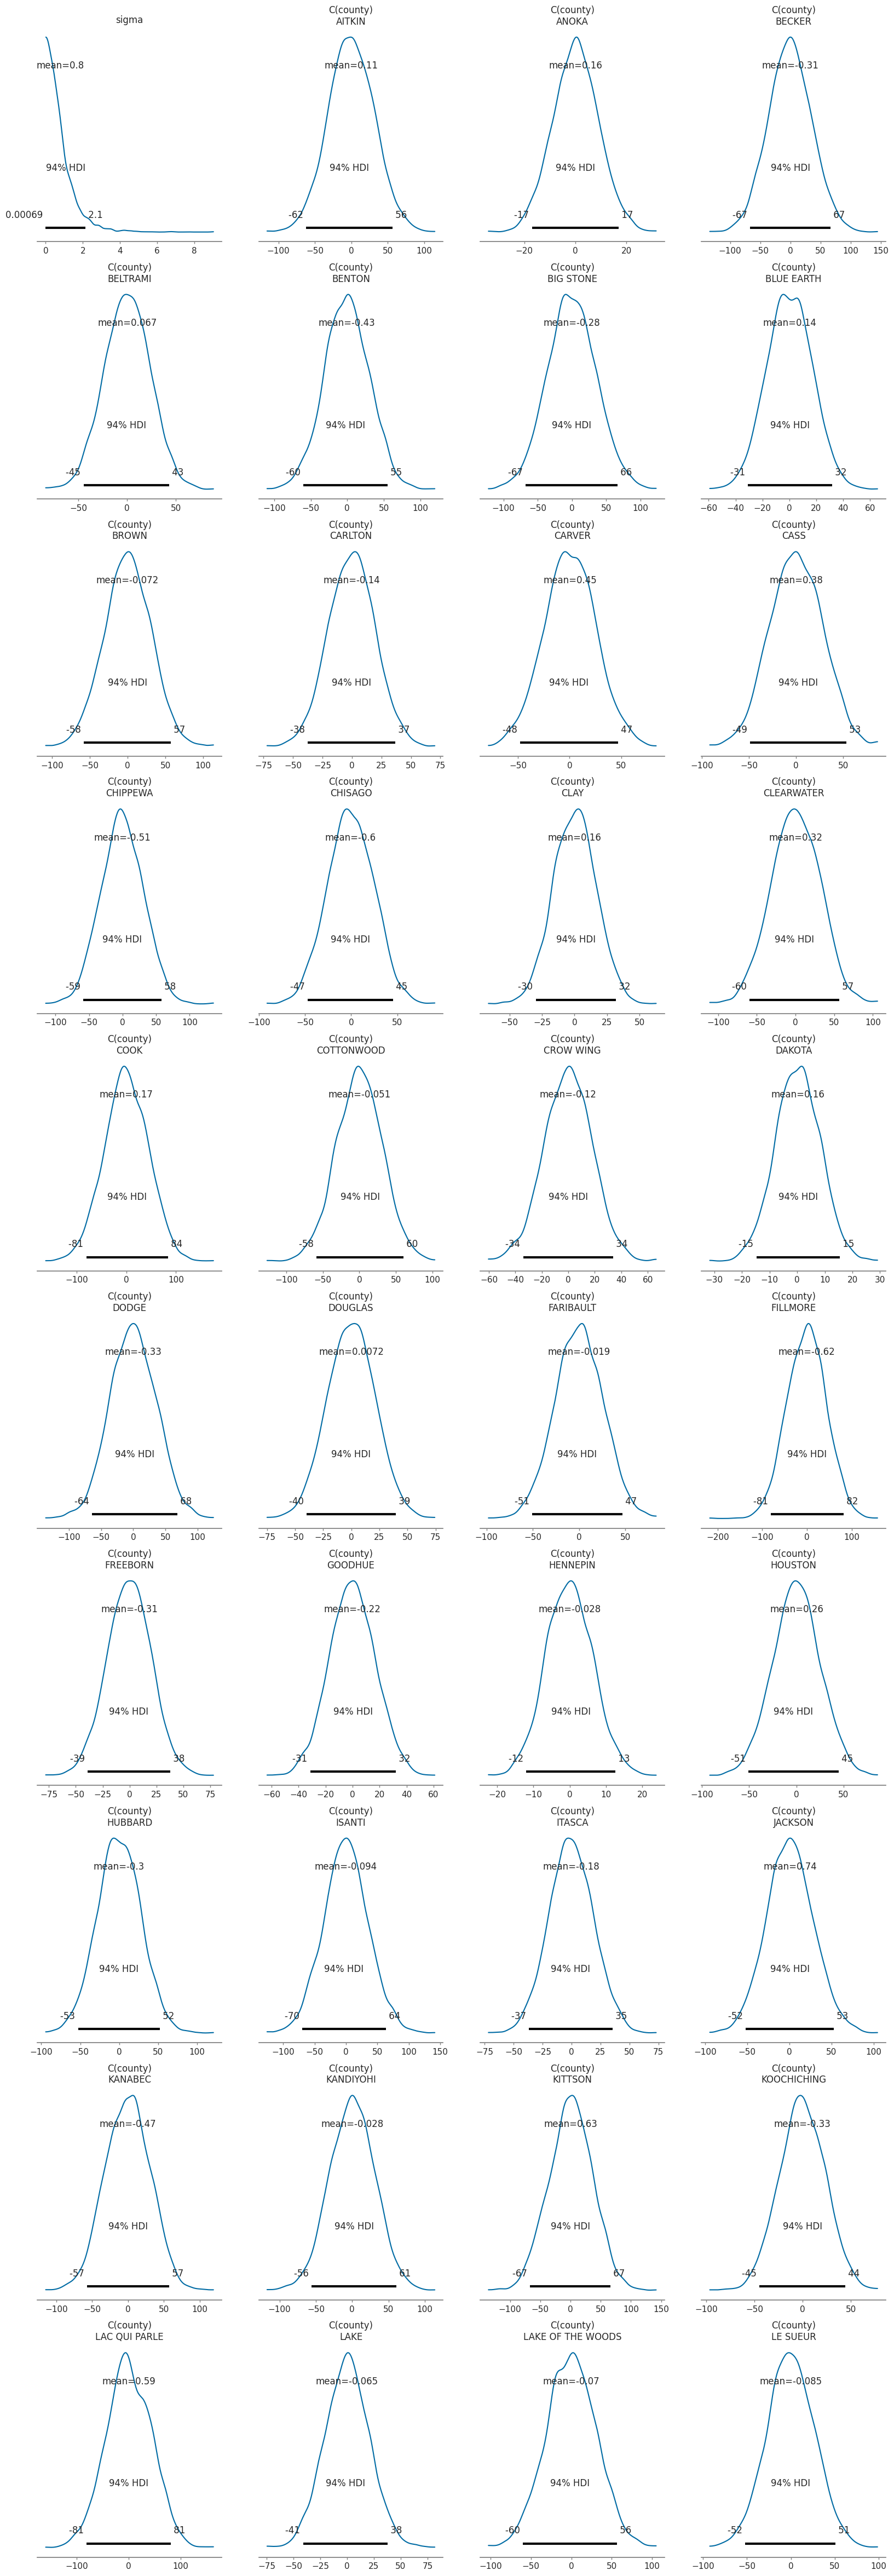

In [ ]:
unpooled_model.plot_priors(figsize=(20,60));

## Fit model

[Fit](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit) the model using PyMC.

`draws`: The number of samples to draw from the posterior distribution. Defaults to `1000`.

`tune`: Number of iterations to tune. Defaults to `1000`.

`chains`: The number of chains to sample. Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior. If `None` (default), then set to either `cores` or `2`, whichever is larger.

`inference_method`: The method to use for fitting the model. By default, [`"mcmc"`](https://www.bayesrulesbook.com/chapter-7). This automatically assigns a [MCMC](https://mc-stan.org/docs/reference-manual/hmc.html) method best suited for each kind of variables, like [NUTS](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html) for continuous variables and [Metropolis](https://mc-stan.org/docs/reference-manual/hmc.html) for non-binary discrete ones. Alternatively, `"vi"`, in which case the model will be fitted using [variational inference](https://mc-stan.org/docs/reference-manual/vi-algorithms.html) as implemented in PyMC using the `fit` function.

[Markov Chain Monte Carlo (MCMC)](https://bookdown.org/content/4857/markov-chain-monte-carlo.html): This chapter introduces one commonplace example of [Fortuna](https://en.wikipedia.org/wiki/Rota_Fortunae#/media/File:Lydgate-siege-troy-wheel-fortune-detail.jpg) and [Minerva](https://en.wikipedia.org/wiki/Minerva#/media/File:Minerva-Vedder-Highsmith-detail-1.jpeg)'s cooperation: the estimation of posterior probability distributions using a stochastic process known as **Markov chain Monte Carlo (MCMC)** ([McElreath, 2020a, p. 263](https://bookdown.org/content/4857/markov-chain-monte-carlo.html#ref-mcelreathStatisticalRethinkingBayesian2020), **emphasis** in the original).

[Model log-likelihood](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood)

In order to compute [`LOO`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) and [`WAIC`](https://python.arviz.org/en/stable/api/generated/arviz.waic.html), [`ArviZ`](https://python.arviz.org/en/stable/index.html) needs access to the model elemwise loglikelihood for every posterior sample. We can pass `idata_kwargs={"log_likelihood": True}` to have it computed automatically at the end of sampling.

In [31]:
unpooled_results = unpooled_model.fit(cores=1, idata_kwargs=dict(log_likelihood=True))

unpooled_results

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

[Introduction to xarray, InferenceData, and netCDF for ArviZ](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html)

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) generates numerous datasets that represent different aspects of the model. For example, in a single analysis, a Bayesian practitioner could end up with any of the following data.

* Prior Distribution for N number of variables

* Posterior Distribution for N number of variables

* Prior Predictive Distribution

* Posterior Predictive Distribution

* Trace data for each of the above

* Sample statistics for each inference run

* Any other array like data source

[`InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html#additional-reading)

* [Working with `InferenceData`](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#working-with-inferencedata): Tutorial covering the most common operations with `InferenceData` objects

* [Creating `InferenceData`](https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#creating-inferencedata): Cookbook with examples of generating `InferenceData` objects from multiple sources, both external inference libraries like

* [data module API reference](https://python.arviz.org/en/stable/api/data.html#data-api)

* [`InferenceData` API reference](https://python.arviz.org/en/stable/api/inference_data.html#idata-api): description of all available `InferenceData` methods, grouped by topic

[`InferenceData` schema specification](https://python.arviz.org/en/stable/schema/schema.html)

* [Terminology](https://python.arviz.org/en/stable/schema/schema.html#terminology)

* [Rules](https://python.arviz.org/en/stable/schema/schema.html#rules)

* [Metadata](https://python.arviz.org/en/stable/schema/schema.html#metadata)

* [Relations between groups](https://python.arviz.org/en/stable/schema/schema.html#relations-between-groups)

* [Example of schema](https://python.arviz.org/en/stable/schema/PyMC3_schema_example.html)

## Plot MCMC diagnostics

[`az.ess`](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): Calculate estimate of the effective sample size (`ess`). The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. The 𝑛𝑒𝑓𝑓 metric used in Stan is based on the ability of the draws to estimate the true mean value of the parameter, which is related to (but not necessarily equivalent to) estimating other functions of the draws. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, 𝑛𝑒𝑓𝑓, is usually smaller than the total sample size, 𝑁 (although it may be larger in some cases1). The larger the ratio of 𝑛𝑒𝑓𝑓 to 𝑁 the better (see Gelman et al. 2013, Stan Development Team 2018 for more details).

[`az.rhat`](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): Compute estimate of rank normalized splitR-hat for a set of traces.  The rank normalized [`R-hat`](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic) diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain.  If convergence has been achieved, the between-chain and within-chain variances should be identical.  To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.


[`az.mcse`](https://python.arviz.org/en/stable/api/generated/arviz.mcse.html): Calculate Markov Chain Standard Error (`mcse`) statistic.  The [Monte Carlo standard error](https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html) is the uncertainty about a statistic in the sample due to sampling error. With a independent sample of size N, the MCSE for the sample mean is MCSE(θbar) = s / √N , where s is the sample standard deviation.
However, MCMC are generally not independent, and the MCSE will be higher than that of an independent sample. One way to calculate the MCSE with autocorrelated samples is to use the effective sample size instead of the sample size, MCSE(θbar) = s / √Neff.

[`az.plot_trace`](https://python.arviz.org/en/stable/examples/plot_trace.html) distribution (histogram or kernel density estimates) and sampled values or rank plot.  If `divergences` data is available in `sample_stats`, will plot the location of divergences as dashed vertical lines.

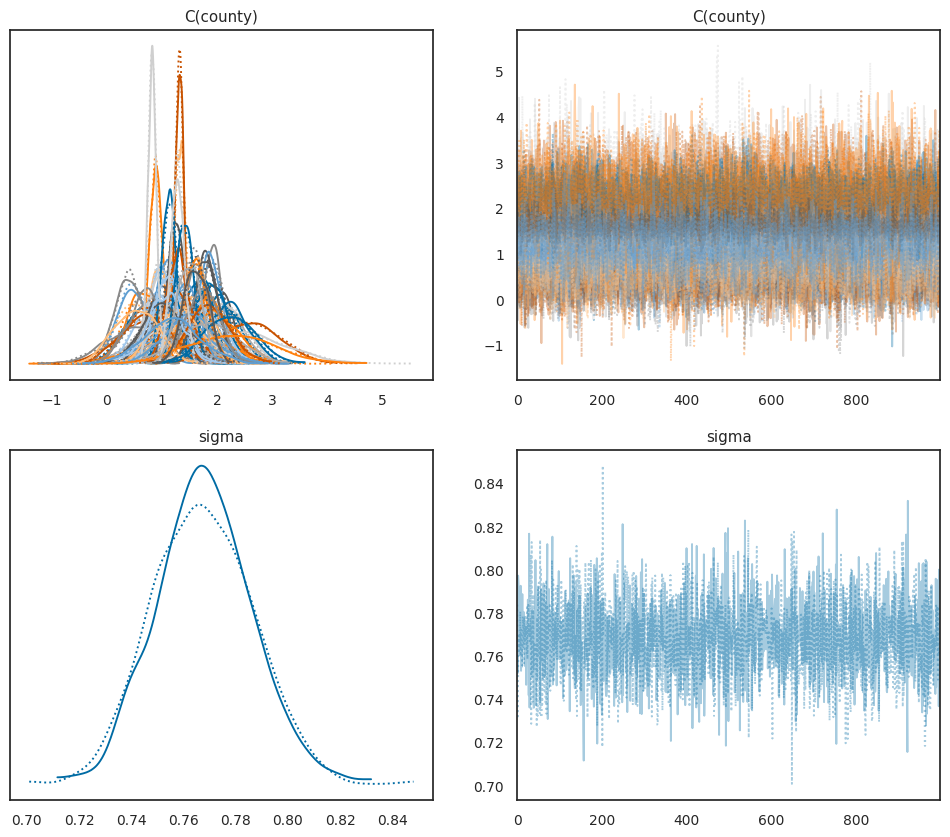

In [ ]:
az.plot_trace(unpooled_results, figsize=(12,10));

## Plot posterior distributions

The [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) is a type of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) that results from [updating](https://en.wikipedia.org/wiki/Bayesian_updating) the [prior probability](https://en.wikipedia.org/wiki/Prior_probability) with information summarized by the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) via an application of [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_rule).

Chapter 7 [The Posterior - The Goal of Bayesian
Inference](https://sites.math.rutgers.edu/~zeilberg/EM20/Lambert.pdf) in "A Student's Guide to Bayesian Statistics" by Ben Lambert

[`az.plot_posterior`](https://python.arviz.org/en/stable/examples/plot_posterior.html): Plot Posterior densities in the style of John K. Kruschke's [book](https://sites.google.com/site/doingbayesiandataanalysis/).

[`az.plot_pair`](https://python.arviz.org/en/stable/examples/plot_pair.html): Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

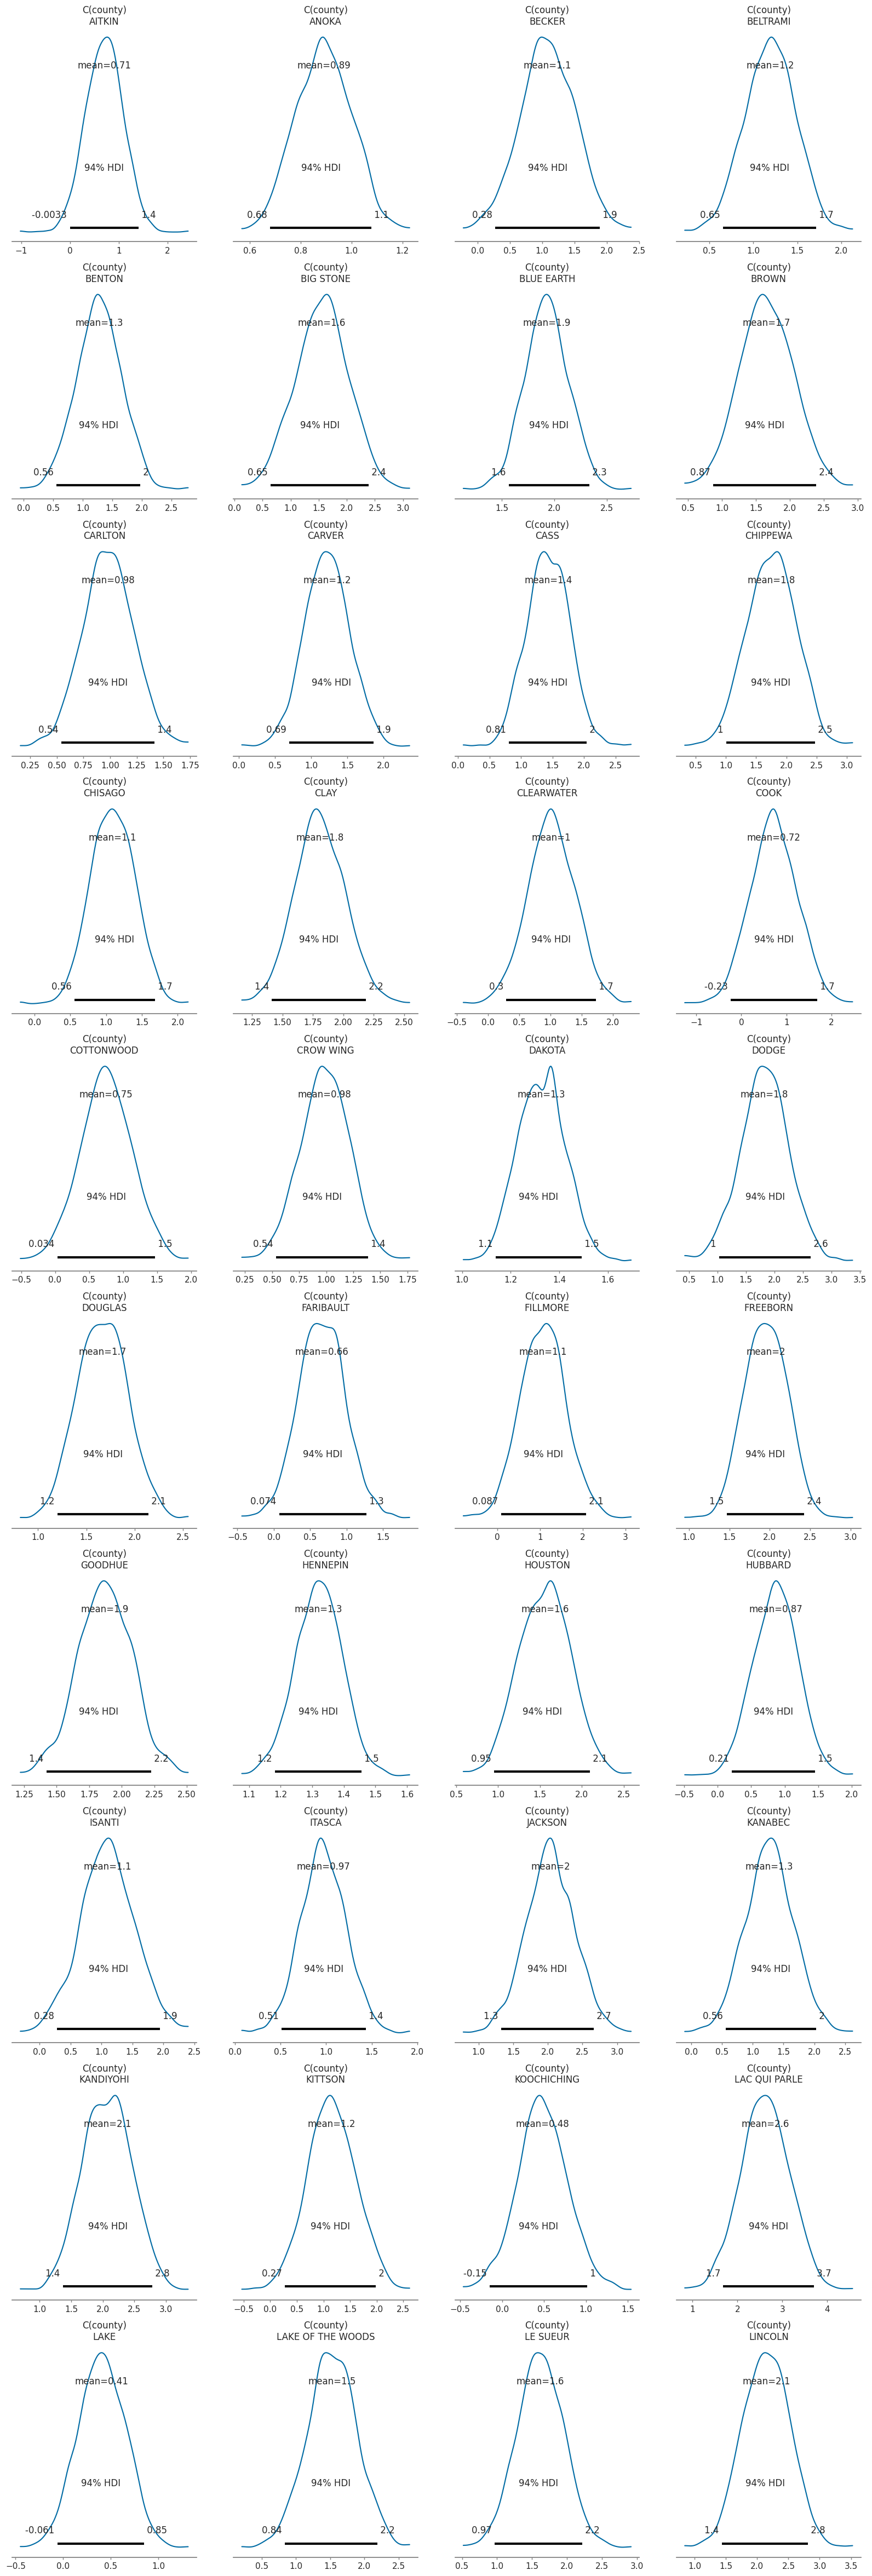

In [ ]:
az.plot_posterior(unpooled_results, figsize=(20,60));

[`az.summary`](https://python.arviz.org/en/stable/api/generated/arviz.summary.html): Create a data frame with summary statistics.

In [ ]:
az.summary(unpooled_results).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
C(county)[AITKIN]           0.71  0.38   -0.00     1.40       0.01     0.01   
C(county)[ANOKA]            0.89  0.11    0.68     1.08       0.00     0.00   
C(county)[BECKER]           1.08  0.43    0.28     1.89       0.01     0.01   
C(county)[BELTRAMI]         1.19  0.29    0.65     1.71       0.00     0.01   
C(county)[BENTON]           1.28  0.38    0.56     1.98       0.01     0.01   
...                          ...   ...     ...      ...        ...      ...   
C(county)[WILKIN]           2.26  0.78    0.78     3.66       0.01     0.02   
C(county)[WINONA]           1.50  0.21    1.11     1.88       0.00     0.00   
C(county)[WRIGHT]           1.62  0.23    1.22     2.07       0.00     0.01   
C(county)[YELLOW MEDICINE]  1.20  0.52    0.23     2.20       0.01     0.01   
sigma                       0.77  0.02    0.73     0.80       0.00     0.00   

                            ess_bulk  ess_tail  r_hat  
C(county)[AITKIN]             4473.0    1270.0    1.0  
C(county)[ANOKA]              2776.0    1056.0    1.0  
C(county)[BECKER]             3076.0    1394.0    1.0  
C(county)[BELTRAMI]           4070.0    1362.0    1.0  
C(county)[BENTON]             3323.0    1439.0    1.0  
...                              ...       ...    ...  
C(county)[WILKIN]             2992.0    1390.0    1.0  
C(county)[WINONA]             3875.0    1383.0    1.0  
C(county)[WRIGHT]             3678.0    1244.0    1.0  
C(county)[YELLOW MEDICINE]    3092.0    1745.0    1.0  
sigma                         2998.0    1726.0    1.0  

[86 rows x 9 columns]

In [ ]:
unpooled_results_df = az.extract(unpooled_results).to_dataframe() # [['basement', 'sigma']]
unpooled_results_df.round(2)

## Plot posterior predictive distributions

[Posterior predictive checks (PPCs)](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism.

[Graphical posterior predictive checks (PPCs)](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html)

The `bayesplot` package provides various plotting functions for graphical posterior predictive checking, that is, creating graphical displays comparing observed data to simulated data from the posterior predictive distribution ([Gabry et al, 2019](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html#gabry2019)).

The idea behind [posterior predictive checking](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) is simple: if a model is a good fit then we should be able to use it to generate data that looks a lot like the data we observed. To generate the data used for posterior predictive checks (PPCs) we simulate from the posterior predictive distribution. This is the distribution of the outcome variable implied by a model after using the observed data 𝑦 (a vector of 𝑁 outcome values) to update our beliefs about unknown model parameters 𝜃.

[Predict method for Bambi models](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)

Obtains in-sample and out-of-sample predictions from a fitted Bambi model.

`kind` indicates the type of prediction required. Can be `"response_params"` or `"response"`. The first returns draws from the posterior distribution of the likelihood parameters, while the latter returns the draws from the posterior predictive distribution (i.e. the posterior probability distribution for a new observation) in addition to the posterior distribution. Defaults to `"response_params"`.

In [ ]:
posterior_predictive = unpooled_model.predict(unpooled_results, kind="response")
unpooled_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

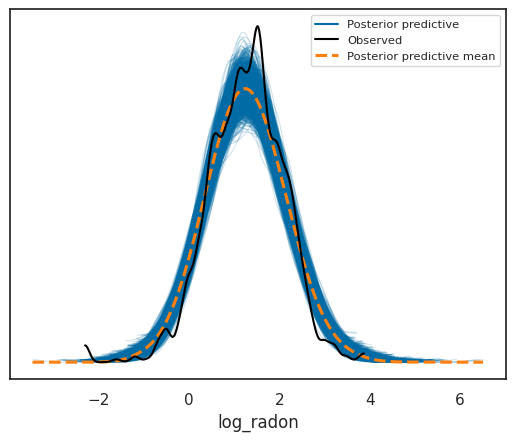

In [ ]:
az.plot_ppc(unpooled_results);

[loo](https://mc-stan.org/loo/index.html): Efficient approximate leave-one-out cross-validation for fitted Bayesian models

From existing posterior simulation draws, we compute approximate `LOO-CV` using Pareto smoothed importance sampling (`PSIS`), a new procedure for regularizing importance weights. As a byproduct of our calculations, we also obtain approximate standard errors for estimated predictive errors and for comparing predictive errors between two models. We recommend `PSIS-LOO-CV` instead of `WAIC`, because `PSIS` provides useful diagnostics and effective sample size and Monte Carlo standard error estimates.

[`az.loo`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html): Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

In [ ]:
loo_unpooled = az.loo(unpooled_results)
loo_unpooled

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1111.97    28.78
p_loo       86.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      908   98.8%
   (0.70, 1]   (bad)        10    1.1%
   (1, Inf)   (very bad)    1    0.1%

[LOO package glossary](https://mc-stan.org/loo/reference/loo-glossary.html)

`elpd`: approximated expected log pointwise predictive density (elpd).

`se`: standard error of the elpd.

`p_loo`: effective number of parameters. If we have a well-specified model, we expect the estimated effective number of parameters (`p_loo`) to be smaller than or similar to the total number of parameters in the model.

Pareto 𝑘 diagnostic values are used to assess the reliability of the estimates. In addition to the proportion of leave-one-out folds with 𝑘 values in different intervals, the minimum of the effective sample sizes in that category is shown to give idea why higher 𝑘 values are bad.

---

## **Partial pooling** without predictors

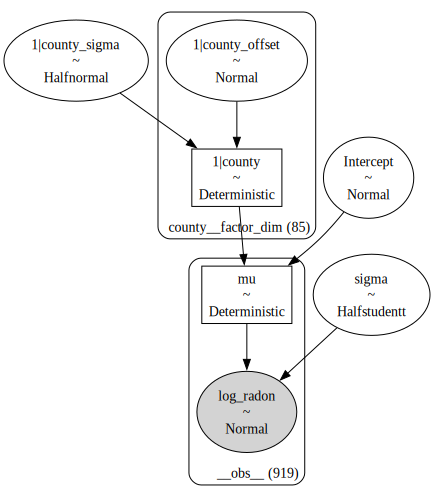

In [22]:
# Fit partial pooling (multilevel) model: varying intercept per county
partial_pooling_model = bmb.Model("log_radon ~ 1 + (1|county)", data=radon)

partial_pooling_model.build()

partial_pooling_model.graph()

## Plot prior parameter distributions

[Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

1. Flat prior (not usually recommended).

2. Super-vague but proper prior: normal(0, 1e6) (not usually recommended).

3. Weakly informative prior, very weak: normal(0, 10).

4. Generic weakly informative prior: normal(0, 1).

5. Specific informative prior: normal(0.4, 0.2) or whatever. Sometimes this can be expressed as a scaling followed by a generic prior: theta = 0.4 + 0.2*z ; z ~ normal(0, 1).

The above numbers assume that parameters are roughly on unit scale, as is done in education (where 0 is average test score in some standard population (e.g., all students at a certain grade level) and 1 is sd of test scores in that population) or medicine (where 0 is zero dose and 1 is a standard dose such as 10mcg/day of cyanocobalamin, 1,000 IU/day cholecalciferol, etc.; these examples come from Sander Greenland).

In addition, statements such as "informative" or "weakly informative" depend crucially on what questions are being asked (a point that is related to the idea that [the prior can often only be understood in the context of the likelihood](http://www.stat.columbia.edu/~gelman/research/published/entropy-19-00555-v2.pdf)).

[Default (Weakly Informative) Prior Distributions](https://mc-stan.org/rstanarm/articles/priors.html)

With very few exceptions, the default priors in [`rstanarm`](https://mc-stan.org/rstanarm/articles/priors.html) —the priors used if they aren't specified— are not flat priors. Rather, the defaults are intended to be weakly informative. That is, they are designed to provide moderate regularization and help stabilize computation. For many (if not most) applications the defaults will perform well, but this is not guaranteed (there are no default priors that make sense for every possible model specification).

[Prior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model - in short, they help you check how credible your assumptions before seeing the data are.

* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

[`Model.plot_priors`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors): Samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors) distribution and plots its marginals.

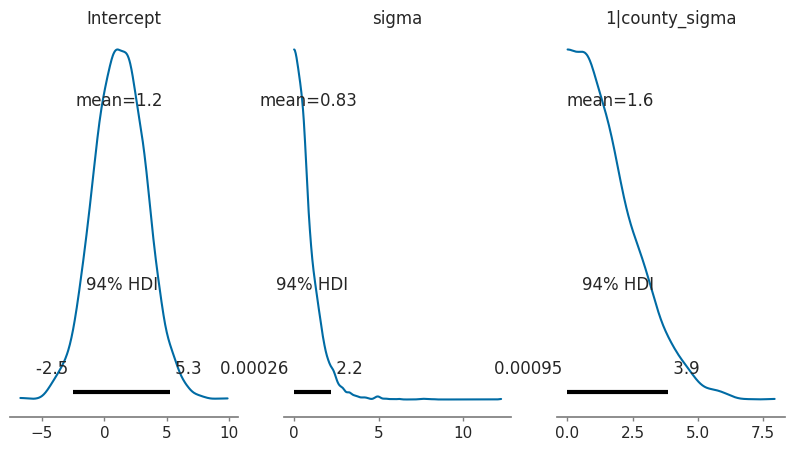

In [ ]:
partial_pooling_model.plot_priors(figsize=(10,5));

## Fit model

[Fit](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit) the model using PyMC.

`draws`: The number of samples to draw from the posterior distribution. Defaults to `1000`.

`tune`: Number of iterations to tune. Defaults to `1000`.

`chains`: The number of chains to sample. Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior. If `None` (default), then set to either `cores` or `2`, whichever is larger.

`inference_method`: The method to use for fitting the model. By default, [`"mcmc"`](https://www.bayesrulesbook.com/chapter-7). This automatically assigns a [MCMC](https://mc-stan.org/docs/reference-manual/hmc.html) method best suited for each kind of variables, like [NUTS](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html) for continuous variables and [Metropolis](https://mc-stan.org/docs/reference-manual/hmc.html) for non-binary discrete ones. Alternatively, `"vi"`, in which case the model will be fitted using [variational inference](https://mc-stan.org/docs/reference-manual/vi-algorithms.html) as implemented in PyMC using the `fit` function.

[Markov Chain Monte Carlo (MCMC)](https://bookdown.org/content/4857/markov-chain-monte-carlo.html): This chapter introduces one commonplace example of [Fortuna](https://en.wikipedia.org/wiki/Rota_Fortunae#/media/File:Lydgate-siege-troy-wheel-fortune-detail.jpg) and [Minerva](https://en.wikipedia.org/wiki/Minerva#/media/File:Minerva-Vedder-Highsmith-detail-1.jpeg)'s cooperation: the estimation of posterior probability distributions using a stochastic process known as **Markov chain Monte Carlo (MCMC)** ([McElreath, 2020a, p. 263](https://bookdown.org/content/4857/markov-chain-monte-carlo.html#ref-mcelreathStatisticalRethinkingBayesian2020), **emphasis** in the original).

[Model log-likelihood](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood)

In order to compute [`LOO`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) and [`WAIC`](https://python.arviz.org/en/stable/api/generated/arviz.waic.html), [`ArviZ`](https://python.arviz.org/en/stable/index.html) needs access to the model elemwise loglikelihood for every posterior sample. We can pass `idata_kwargs={"log_likelihood": True}` to have it computed automatically at the end of sampling.

In [23]:
partial_pooling_results = partial_pooling_model.fit(idata_kwargs=dict(log_likelihood=True))

partial_pooling_results

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

[Introduction to xarray, InferenceData, and netCDF for ArviZ](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html)

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) generates numerous datasets that represent different aspects of the model. For example, in a single analysis, a Bayesian practitioner could end up with any of the following data.

* Prior Distribution for N number of variables

* Posterior Distribution for N number of variables

* Prior Predictive Distribution

* Posterior Predictive Distribution

* Trace data for each of the above

* Sample statistics for each inference run

* Any other array like data source

[`InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html#additional-reading)

* [Working with `InferenceData`](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#working-with-inferencedata): Tutorial covering the most common operations with `InferenceData` objects

* [Creating `InferenceData`](https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#creating-inferencedata): Cookbook with examples of generating `InferenceData` objects from multiple sources, both external inference libraries like

* [data module API reference](https://python.arviz.org/en/stable/api/data.html#data-api)

* [`InferenceData` API reference](https://python.arviz.org/en/stable/api/inference_data.html#idata-api): description of all available `InferenceData` methods, grouped by topic

[`InferenceData` schema specification](https://python.arviz.org/en/stable/schema/schema.html)

* [Terminology](https://python.arviz.org/en/stable/schema/schema.html#terminology)

* [Rules](https://python.arviz.org/en/stable/schema/schema.html#rules)

* [Metadata](https://python.arviz.org/en/stable/schema/schema.html#metadata)

* [Relations between groups](https://python.arviz.org/en/stable/schema/schema.html#relations-between-groups)

* [Example of schema](https://python.arviz.org/en/stable/schema/PyMC3_schema_example.html)

## Plot MCMC diagnostics

[`az.ess`](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): Calculate estimate of the effective sample size (`ess`). The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. The 𝑛𝑒𝑓𝑓 metric used in Stan is based on the ability of the draws to estimate the true mean value of the parameter, which is related to (but not necessarily equivalent to) estimating other functions of the draws. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, 𝑛𝑒𝑓𝑓, is usually smaller than the total sample size, 𝑁 (although it may be larger in some cases1). The larger the ratio of 𝑛𝑒𝑓𝑓 to 𝑁 the better (see Gelman et al. 2013, Stan Development Team 2018 for more details).

[`az.rhat`](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): Compute estimate of rank normalized splitR-hat for a set of traces.  The rank normalized [`R-hat`](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic) diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain.  If convergence has been achieved, the between-chain and within-chain variances should be identical.  To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.


[`az.mcse`](https://python.arviz.org/en/stable/api/generated/arviz.mcse.html): Calculate Markov Chain Standard Error (`mcse`) statistic.  The [Monte Carlo standard error](https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html) is the uncertainty about a statistic in the sample due to sampling error. With a independent sample of size N, the MCSE for the sample mean is MCSE(θbar) = s / √N , where s is the sample standard deviation.
However, MCMC are generally not independent, and the MCSE will be higher than that of an independent sample. One way to calculate the MCSE with autocorrelated samples is to use the effective sample size instead of the sample size, MCSE(θbar) = s / √Neff.

[`az.plot_trace`](https://python.arviz.org/en/stable/examples/plot_trace.html) distribution (histogram or kernel density estimates) and sampled values or rank plot.  If `divergences` data is available in `sample_stats`, will plot the location of divergences as dashed vertical lines.

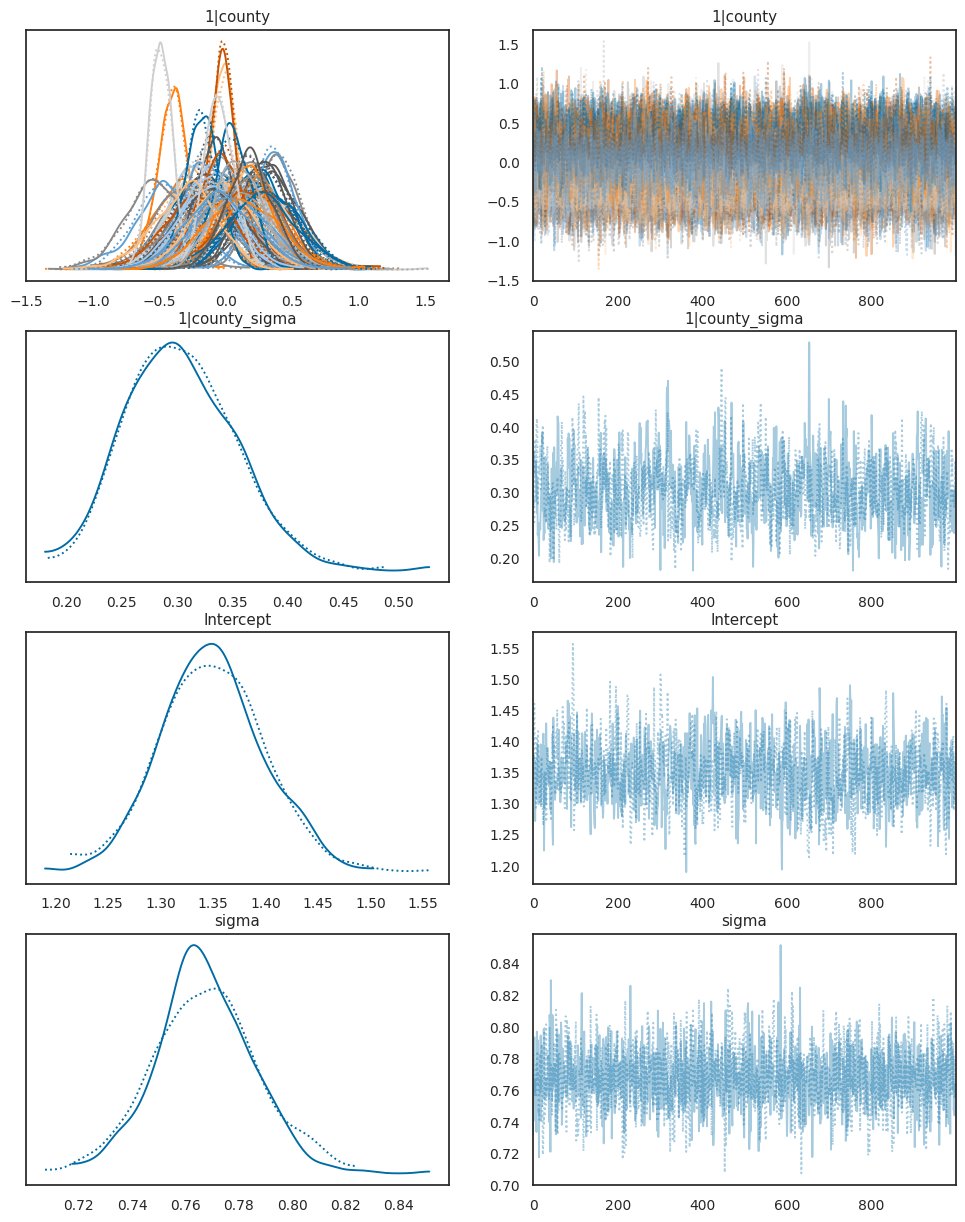

In [ ]:
az.plot_trace(partial_pooling_results, figsize=(12,15));

## Plot posterior distributions

The [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) is a type of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) that results from [updating](https://en.wikipedia.org/wiki/Bayesian_updating) the [prior probability](https://en.wikipedia.org/wiki/Prior_probability) with information summarized by the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) via an application of [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_rule).

Chapter 7 [The Posterior - The Goal of Bayesian
Inference](https://sites.math.rutgers.edu/~zeilberg/EM20/Lambert.pdf) in "A Student's Guide to Bayesian Statistics" by Ben Lambert

[`az.plot_posterior`](https://python.arviz.org/en/stable/examples/plot_posterior.html): Plot Posterior densities in the style of John K. Kruschke's [book](https://sites.google.com/site/doingbayesiandataanalysis/).

[`az.plot_pair`](https://python.arviz.org/en/stable/examples/plot_pair.html): Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

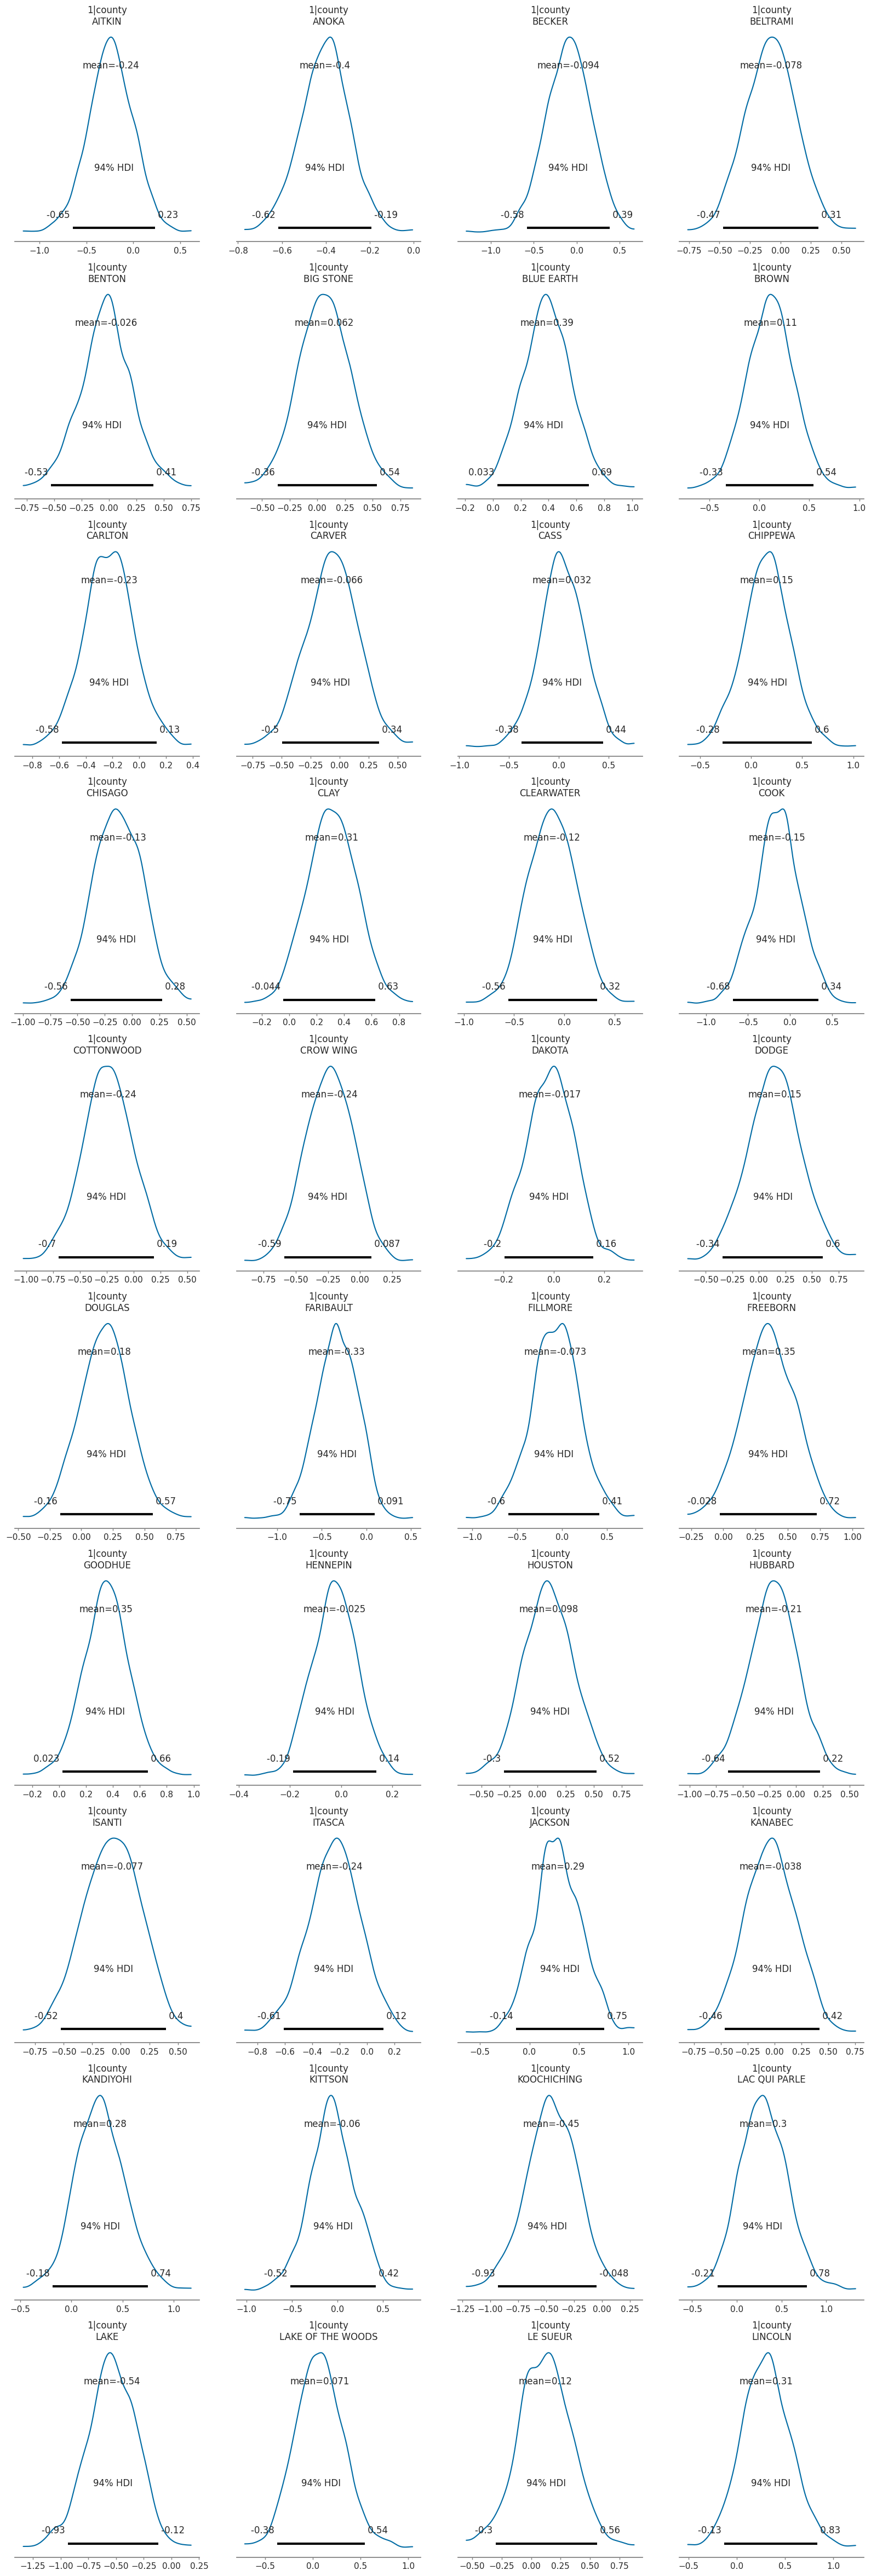

In [ ]:
az.plot_posterior(partial_pooling_results, figsize=(20, 60));

[`az.summary`](https://python.arviz.org/en/stable/api/generated/arviz.summary.html): Create a data frame with summary statistics.

In [ ]:
az.summary(partial_pooling_results).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|county[AITKIN]          -0.24  0.24   -0.65     0.23       0.00     0.01   
1|county[ANOKA]           -0.40  0.11   -0.62    -0.19       0.00     0.00   
1|county[BECKER]          -0.09  0.26   -0.58     0.39       0.01     0.01   
1|county[BELTRAMI]        -0.08  0.21   -0.47     0.31       0.00     0.00   
1|county[BENTON]          -0.03  0.24   -0.53     0.41       0.00     0.01   
...                         ...   ...     ...      ...        ...      ...   
1|county[WRIGHT]           0.18  0.18   -0.15     0.52       0.00     0.00   
1|county[YELLOW MEDICINE] -0.04  0.27   -0.54     0.46       0.01     0.01   
1|county_sigma             0.30  0.05    0.21     0.40       0.00     0.00   
Intercept                  1.35  0.05    1.26     1.44       0.00     0.00   
sigma                      0.77  0.02    0.73     0.80       0.00     0.00   

                           ess_bulk  ess_tail  r_hat  
1|county[AITKIN]             2328.0    1506.0    1.0  
1|county[ANOKA]              1670.0    1364.0    1.0  
1|county[BECKER]             1768.0    1150.0    1.0  
1|county[BELTRAMI]           1682.0    1334.0    1.0  
1|county[BENTON]             2619.0    1225.0    1.0  
...                             ...       ...    ...  
1|county[WRIGHT]             2745.0    1427.0    1.0  
1|county[YELLOW MEDICINE]    2325.0    1375.0    1.0  
1|county_sigma                610.0     963.0    1.0  
Intercept                     804.0     933.0    1.0  
sigma                        1646.0    1272.0    1.0  

[88 rows x 9 columns]

In [24]:
partial_pooling_results_df = az.extract(partial_pooling_results).to_dataframe() # [['basement', 'sigma']]
partial_pooling_results_df.round(2)

sigma  Intercept  1|county_sigma  1|county  \
chain draw county__factor_dim                                               
0     0    AITKIN               0.80       1.35            0.32     -0.50   
           ANOKA                0.80       1.35            0.32     -0.56   
           BECKER               0.80       1.35            0.32     -0.23   
           BELTRAMI             0.80       1.35            0.32      0.10   
           BENTON               0.80       1.35            0.32      0.31   
...                              ...        ...             ...       ...   
3     999  WATONWAN             0.75       1.38            0.34      0.41   
           WILKIN               0.75       1.38            0.34     -0.13   
           WINONA               0.75       1.38            0.34      0.16   
           WRIGHT               0.75       1.38            0.34      0.34   
           YELLOW MEDICINE      0.75       1.38            0.34      0.20   

                               chain  draw  
chain draw county__factor_dim               
0     0    AITKIN                  0     0  
           ANOKA                   0     0  
           BECKER                  0     0  
           BELTRAMI                0     0  
           BENTON                  0     0  
...                              ...   ...  
3     999  WATONWAN                3   999  
           WILKIN                  3   999  
           WINONA                  3   999  
           WRIGHT                  3   999  
           YELLOW MEDICINE         3   999  

[340000 rows x 6 columns]

## Plot posterior predictive distributions

[Posterior predictive checks (PPCs)](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism.

[Graphical posterior predictive checks (PPCs)](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html)

The `bayesplot` package provides various plotting functions for graphical posterior predictive checking, that is, creating graphical displays comparing observed data to simulated data from the posterior predictive distribution ([Gabry et al, 2019](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html#gabry2019)).

The idea behind [posterior predictive checking](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) is simple: if a model is a good fit then we should be able to use it to generate data that looks a lot like the data we observed. To generate the data used for posterior predictive checks (PPCs) we simulate from the posterior predictive distribution. This is the distribution of the outcome variable implied by a model after using the observed data 𝑦 (a vector of 𝑁 outcome values) to update our beliefs about unknown model parameters 𝜃.

[Predict method for Bambi models](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)

Obtains in-sample and out-of-sample predictions from a fitted Bambi model.

`kind` indicates the type of prediction required. Can be `"response_params"` or `"response"`. The first returns draws from the posterior distribution of the likelihood parameters, while the latter returns the draws from the posterior predictive distribution (i.e. the posterior probability distribution for a new observation) in addition to the posterior distribution. Defaults to `"response_params"`.

In [ ]:
posterior_predictive = partial_pooling_model.predict(partial_pooling_results, kind="response")
partial_pooling_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

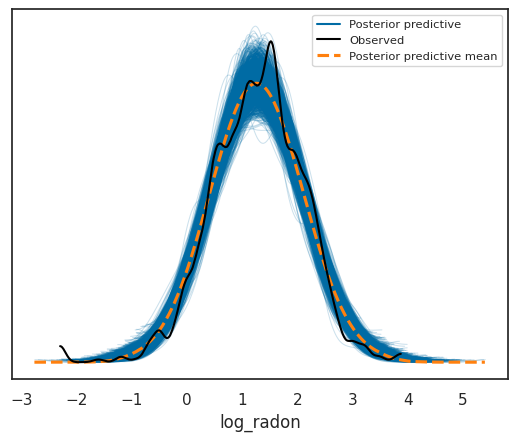

In [ ]:
az.plot_ppc(partial_pooling_results);

[loo](https://mc-stan.org/loo/index.html): Efficient approximate leave-one-out cross-validation for fitted Bayesian models

From existing posterior simulation draws, we compute approximate `LOO-CV` using Pareto smoothed importance sampling (`PSIS`), a new procedure for regularizing importance weights. As a byproduct of our calculations, we also obtain approximate standard errors for estimated predictive errors and for comparing predictive errors between two models. We recommend `PSIS-LOO-CV` instead of `WAIC`, because `PSIS` provides useful diagnostics and effective sample size and Monte Carlo standard error estimates.

[`az.loo`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html): Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

In [ ]:
loo_partial_pooled = az.loo(partial_pooling_results)
loo_partial_pooled

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1084.17    28.73
p_loo       44.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      919  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

[LOO package glossary](https://mc-stan.org/loo/reference/loo-glossary.html)

`elpd`: approximated expected log pointwise predictive density (elpd).

`se`: standard error of the elpd.

`p_loo`: effective number of parameters. If we have a well-specified model, we expect the estimated effective number of parameters (`p_loo`) to be smaller than or similar to the total number of parameters in the model.

Pareto 𝑘 diagnostic values are used to assess the reliability of the estimates. In addition to the proportion of leave-one-out folds with 𝑘 values in different intervals, the minimum of the effective sample sizes in that category is shown to give idea why higher 𝑘 values are bad.

---

# Compare models

In [ ]:
compare_dict = {"Model 1": loo_pooled,
                "Model 2": loo_unpooled,
                "Model 3": loo_partial_pooled}

az.compare(compare_dict).round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se   dse  warning scale
Model 3     0  -1084.17  44.97       0.00    0.92  28.73  0.00    False   log
Model 2     1  -1111.97  86.69      27.80    0.00  28.78  6.75     True   log
Model 1     2  -1122.66   2.48      38.49    0.08  25.92  9.24    False   log

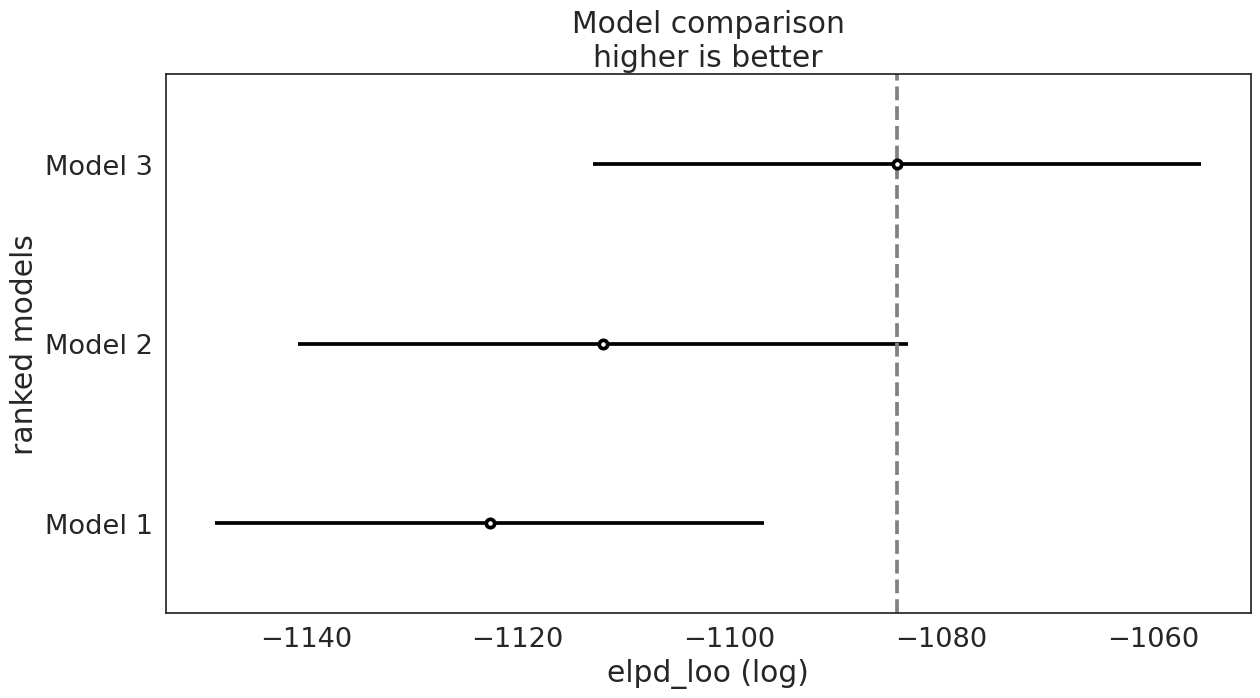

In [ ]:
az.plot_compare(az.compare(compare_dict), figsize=(14, 7));

---

## Reproduce Figure 12.1 from [Data Analysis Using Regression and Multilevel/Hierarchical Models](https://sites.stat.columbia.edu/gelman/arm/)

**Figure 12.1** Estimates $\pm$ standard errors for the average log radon levels in Minnesota counties plotted versus the (jittered) number of observations in the county: (a) no-pooling analysis, (b) multilevel (partial pooling) analysis, in both caes with no house-level or county-level predictors. The counties with fewer measurements have more variable estimates and larger standard errors. The horizontal line in each plot represents an estimate of the average radon level across all counties. The left plot illustrates a problem with the no-pooling analysis: it systematically causes us to think that certain counties are more extreme, just because they have smaller samples sizes.

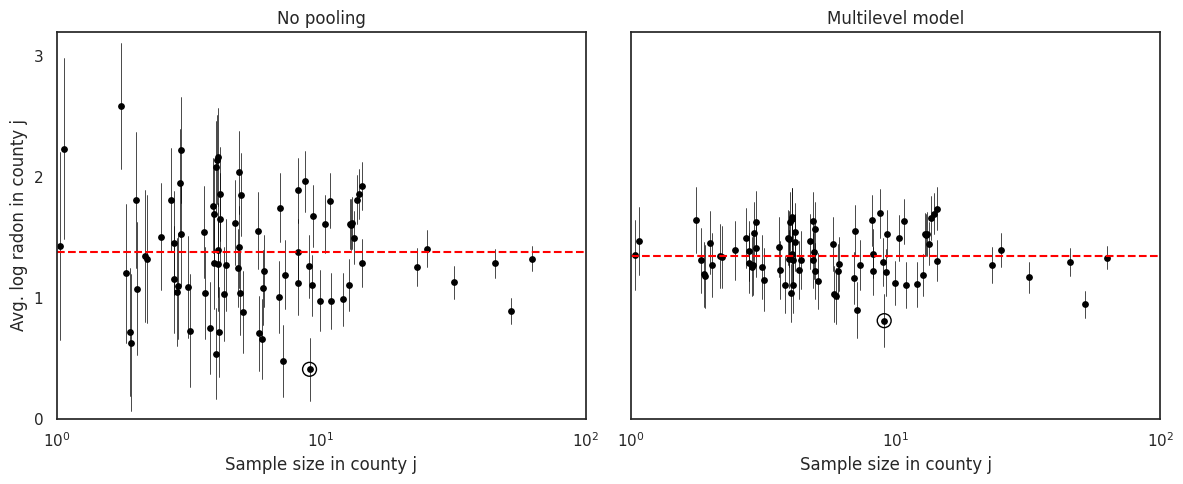

In [ ]:
# @title
# --- PREP COMMON INFO ---
# County sample sizes
county_sample_size = radon.groupby("county").size()
J = len(county_sample_size)

# Jitter x-axis slightly
np.random.seed(42)
sample_size_jittered = county_sample_size.values + np.random.normal(0, 0.2, J)

# --- UNPOOLED MODEL SUMMARIES ---
unpooled_summary = az.summary(unpooled_results, var_names=["C(county)"], kind="stats")
cty_mns = unpooled_summary["mean"].values
cty_sds = unpooled_summary["sd"].values
overall_mean_unpooled = np.mean(cty_mns)

# --- PARTIAL POOLING MODEL SUMMARIES ---
partial_summary = az.summary(partial_pooling_results, var_names=["1|county"], kind="stats")
partial_mean = partial_summary["mean"].values
partial_sd = partial_summary["sd"].values

# Extract global intercept (μₐ)
mu_a = az.summary(partial_pooling_results, var_names=["Intercept"], kind="stats")["mean"].values[0]

# Add the global intercept to county random effects
county_estimates = mu_a + partial_mean

# --- PLOTTING (Two panels side-by-side) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# (a) No pooling
ax = axes[0]
ax.scatter(sample_size_jittered, cty_mns, s=15, color="black")
for j in range(J):
    ax.plot([sample_size_jittered[j]]*2,
            [cty_mns[j]-cty_sds[j], cty_mns[j]+cty_sds[j]],
            color="black", linewidth=0.5)
ax.axhline(overall_mean_unpooled, color="red", linestyle="--", linewidth=1.5)
ax.set_xscale("log")
ax.set_xlim(1, 100)
ax.set_ylim(0, 3.2)
ax.set_xticks([1, 3, 10, 30, 100])
ax.set_yticks(np.arange(0, 3.1, 1))
ax.set_xlabel("Sample size in county j")
ax.set_ylabel("Avg. log radon in county j")
ax.set_title("No pooling")

# Highlight one example county (e.g., index 36, as in R code)
highlight = 36
ax.scatter(sample_size_jittered[highlight], cty_mns[highlight],
           s=100, facecolors='none', edgecolors='black')

# (b) Multilevel model
ax = axes[1]
ax.scatter(sample_size_jittered, county_estimates, s=15, color="black")
for j in range(J):
    ax.plot([sample_size_jittered[j]]*2,
            [county_estimates[j]-partial_sd[j], county_estimates[j]+partial_sd[j]],
            color="black", linewidth=0.5)
ax.axhline(mu_a, color="red", linestyle="--", linewidth=1.5)
ax.set_xscale("log")
ax.set_xlim(1, 100)
ax.set_ylim(0, 3.2)
ax.set_xticks([1, 3, 10, 30, 100])
ax.set_yticks(np.arange(0, 3.1, 1))
ax.set_xlabel("Sample size in county j")
ax.set_title("Multilevel model")

# Highlight same example county
ax.scatter(sample_size_jittered[highlight], county_estimates[highlight],
           s=100, facecolors='none', edgecolors='black')

plt.tight_layout()
plt.show()

---

## **Complete pooling** with predictors

In [25]:
radon['floor'] = radon['floor'].map({'Basement': 0, 'Floor': 1})

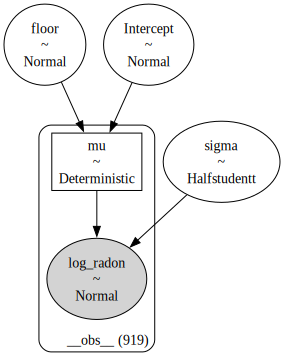

In [26]:
pooled_model = bmb.Model("log_radon ~ floor", data=radon)

pooled_model.build()

pooled_model.graph()

In [27]:
pooled_results = pooled_model.fit(idata_kwargs=dict(log_likelihood=True))

pooled_results

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

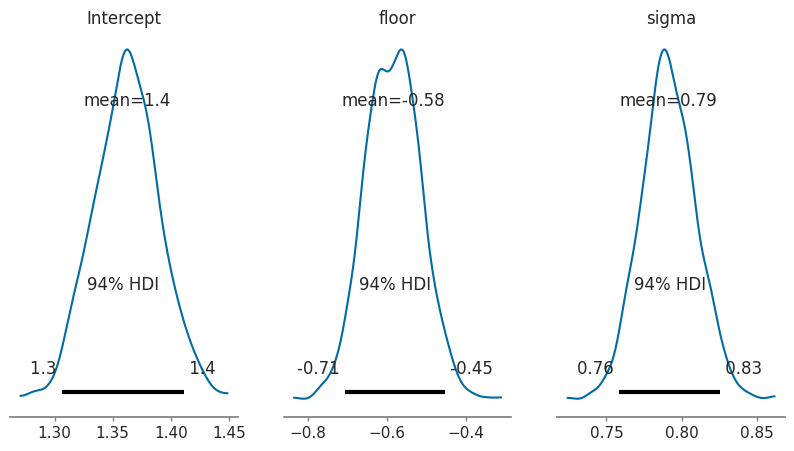

In [ ]:
az.plot_posterior(pooled_results, figsize=(10,5));

In [ ]:
az.summary(pooled_results).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  1.36  0.03    1.31     1.41        0.0      0.0    3552.0   
floor     -0.58  0.07   -0.71    -0.45        0.0      0.0    3172.0   
sigma      0.79  0.02    0.76     0.83        0.0      0.0    2545.0   

           ess_tail  r_hat  
Intercept    1555.0    1.0  
floor        1262.0    1.0  
sigma        1281.0    1.0

In [ ]:
posterior_predictive = pooled_model.predict(pooled_results, kind="response")
pooled_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

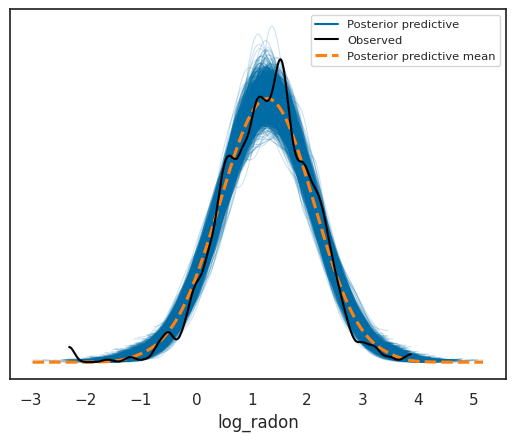

In [ ]:
az.plot_ppc(pooled_results);

In [ ]:
loo_pooled = az.loo(pooled_results)
loo_pooled

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1089.78    24.99
p_loo        3.63        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      919  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

---

## **No pooling** with predictors

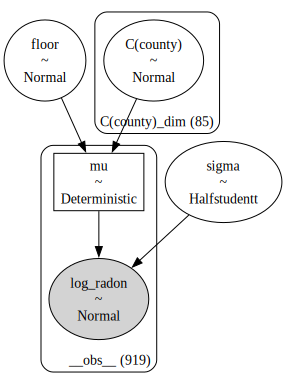

In [28]:
unpooled_model = bmb.Model("log_radon ~ 0 + floor + C(county)", data=radon)

unpooled_model.build()

unpooled_model.graph()

In [30]:
unpooled_results = unpooled_model.fit(cores=1, idata_kwargs=dict(log_likelihood=True))

unpooled_results

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

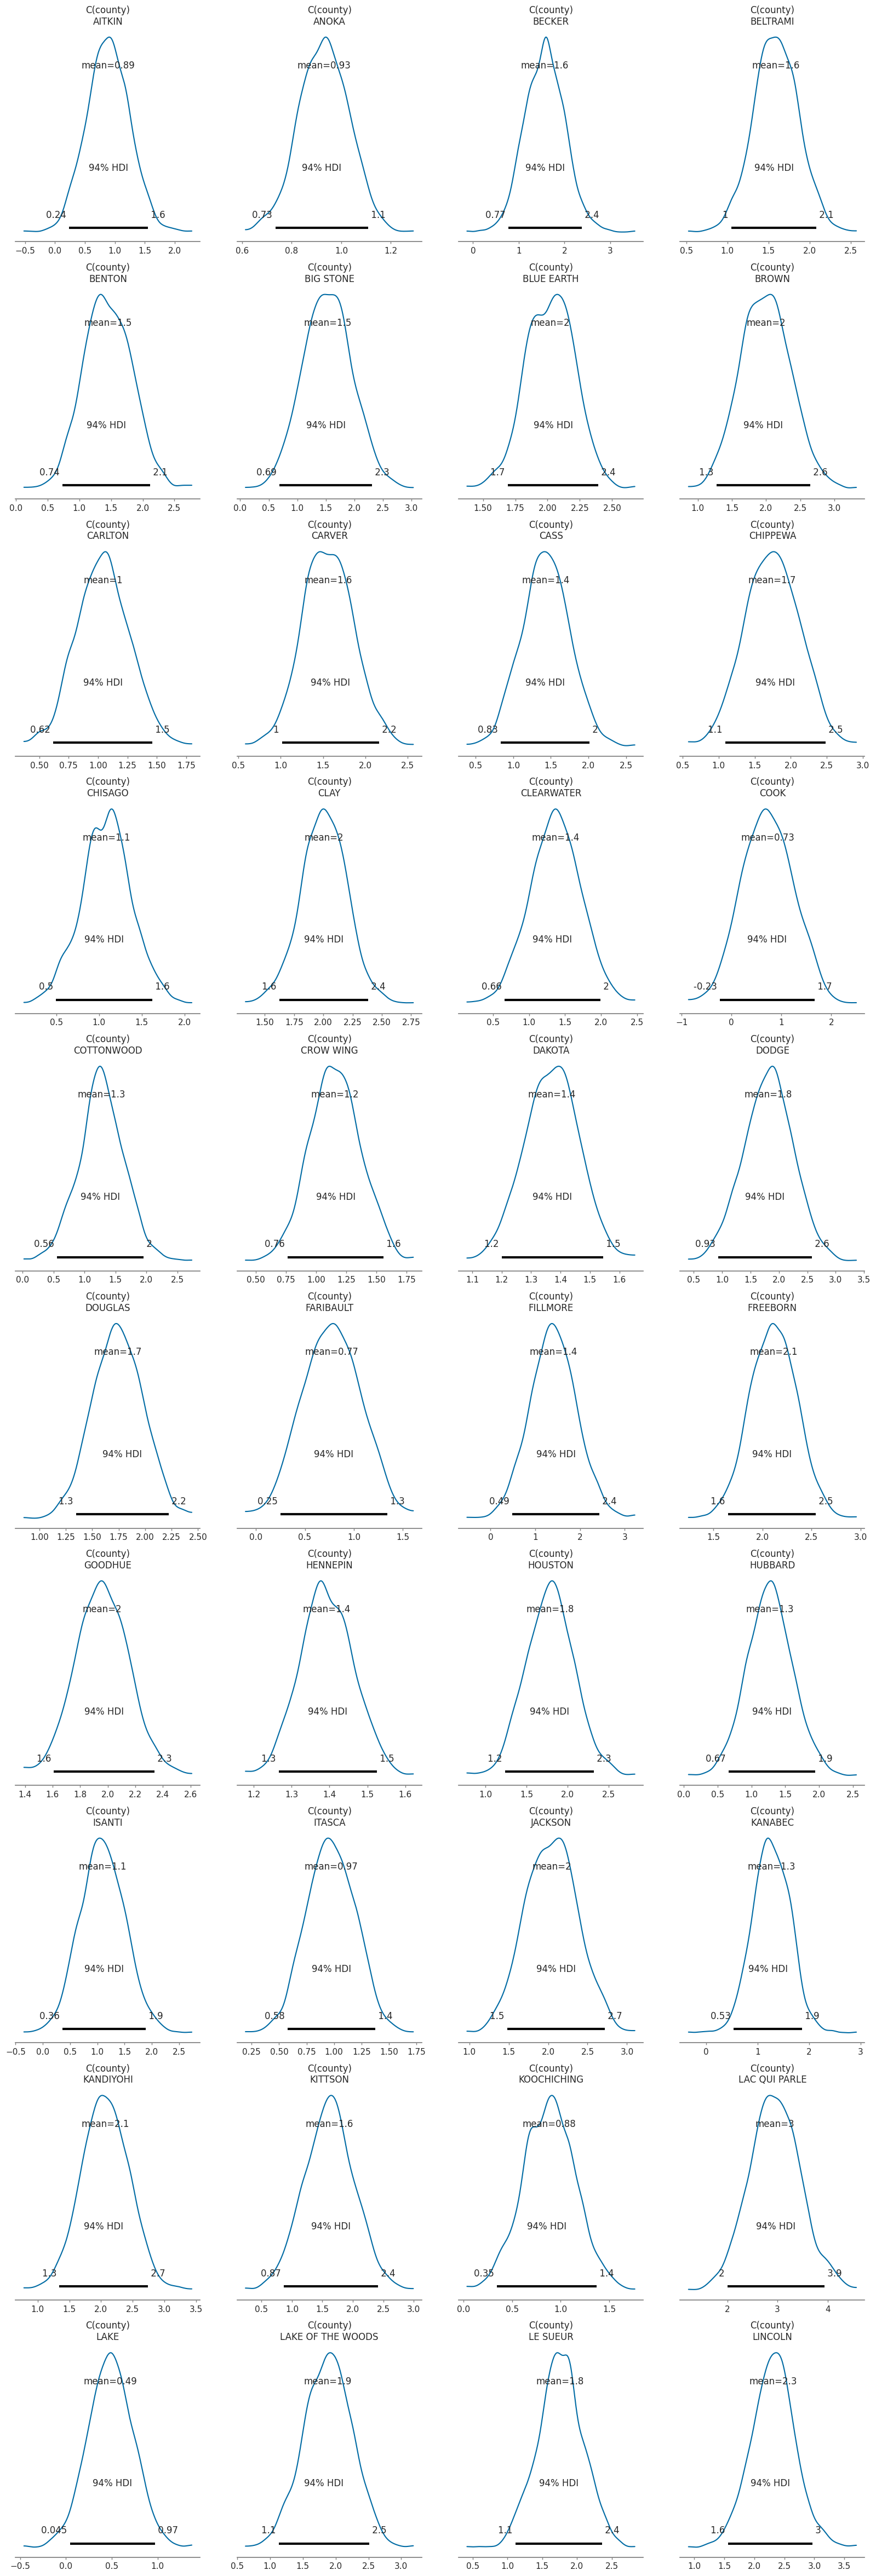

In [ ]:
az.plot_posterior(unpooled_results, figsize=(20,60));

In [ ]:
az.summary(unpooled_results).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
C(county)[AITKIN]           0.89  0.36    0.24     1.56       0.01     0.01   
C(county)[ANOKA]            0.93  0.10    0.73     1.11       0.00     0.00   
C(county)[BECKER]           1.57  0.44    0.77     2.38       0.01     0.01   
C(county)[BELTRAMI]         1.59  0.27    1.05     2.08       0.00     0.01   
C(county)[BENTON]           1.45  0.38    0.74     2.11       0.00     0.01   
...                          ...   ...     ...      ...        ...      ...   
C(county)[WINONA]           1.66  0.20    1.28     2.05       0.00     0.00   
C(county)[WRIGHT]           1.67  0.20    1.29     2.05       0.00     0.00   
C(county)[YELLOW MEDICINE]  1.23  0.53    0.25     2.23       0.01     0.01   
floor                      -0.69  0.07   -0.82    -0.56       0.00     0.00   
sigma                       0.73  0.02    0.70     0.76       0.00     0.00   

                            ess_bulk  ess_tail  r_hat  
C(county)[AITKIN]             3327.0    1409.0   1.01  
C(county)[ANOKA]              3381.0    1582.0   1.00  
C(county)[BECKER]             3597.0    1264.0   1.00  
C(county)[BELTRAMI]           4776.0    1210.0   1.00  
C(county)[BENTON]             5129.0    1229.0   1.00  
...                              ...       ...    ...  
C(county)[WINONA]             3540.0    1517.0   1.00  
C(county)[WRIGHT]             4348.0    1471.0   1.00  
C(county)[YELLOW MEDICINE]    4547.0    1582.0   1.00  
floor                         2290.0    1781.0   1.00  
sigma                         2783.0    1397.0   1.00  

[87 rows x 9 columns]

In [ ]:
posterior_predictive = unpooled_model.predict(unpooled_results, kind="response")
unpooled_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

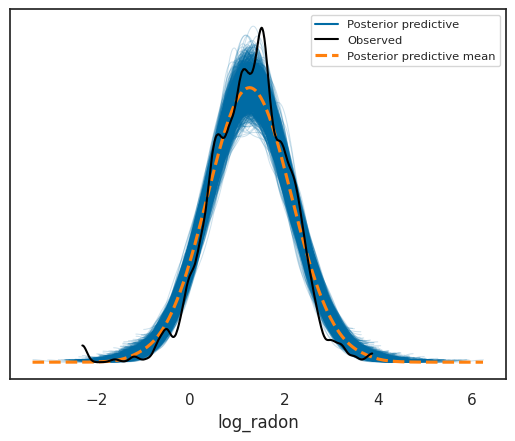

In [ ]:
az.plot_ppc(unpooled_results);

In [ ]:
loo_unpooled = az.loo(unpooled_results)
loo_unpooled

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1064.42    28.65
p_loo       88.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      909   98.9%
   (0.70, 1]   (bad)         9    1.0%
   (1, Inf)   (very bad)    1    0.1%

---

## Reproduce Figure 12.2 from [Data Analysis Using Regression and Multilevel/Hierarchical Models](https://sites.stat.columbia.edu/gelman/arm/)

**Figure 12.2** Complete-pooling (dashed lines, $y = α + βx$) and no-pooling (solid lines, $y = α_{j} + βx$) regressions fit to radon data from 85 counties in Minnesota, and displayed for eight of the counties. The estimated slopes $β$ differ slightly for the two models, but here our focus is on the intercepts.

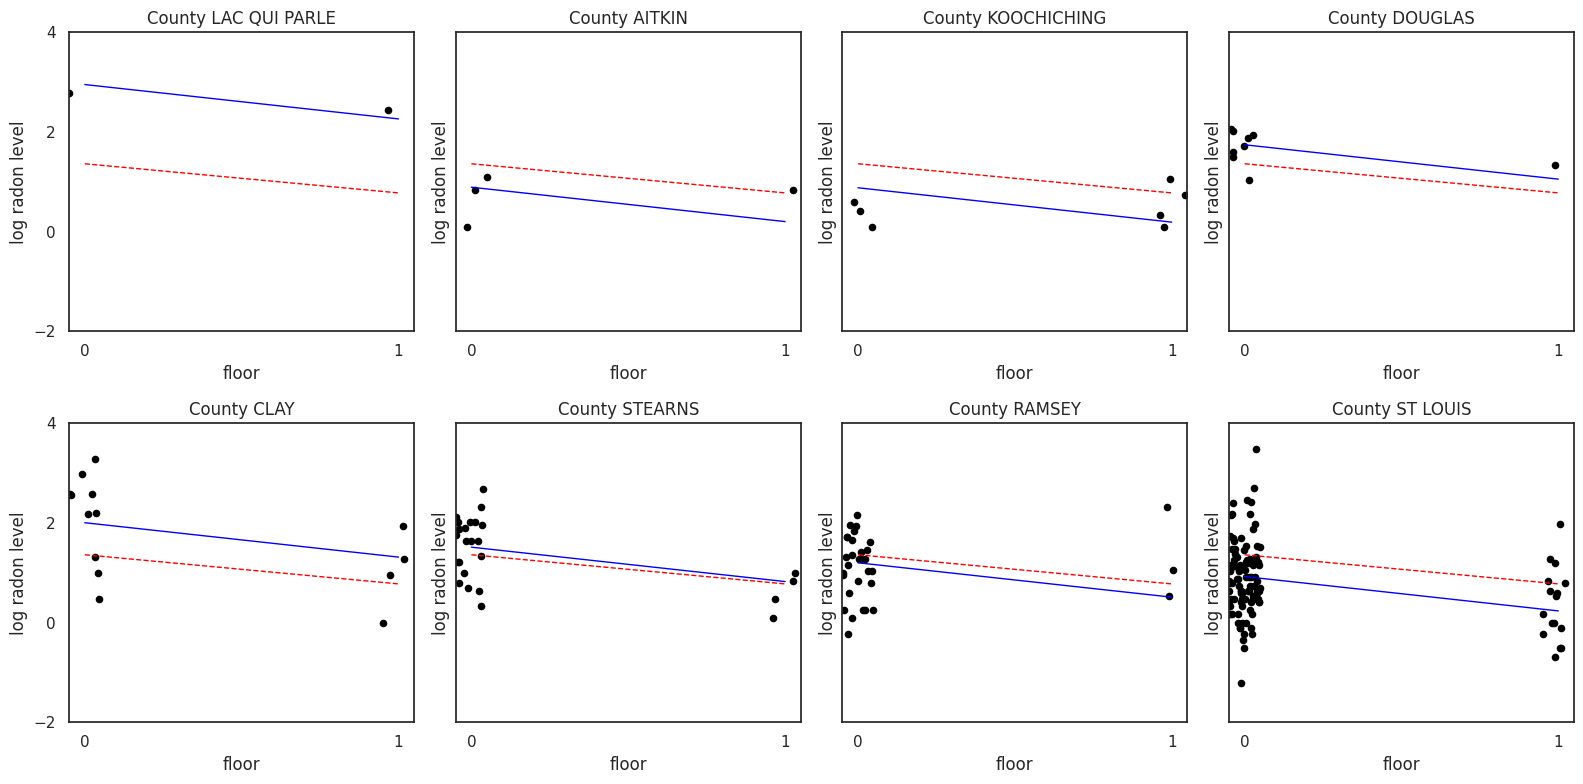

In [ ]:
# @title
# --- PREP DATA ---
x = radon["floor"].values
y = radon["log_radon"].values
county = radon["county"].values

# Jitter x slightly
np.random.seed(42)
x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))

# Select 8 counties by name to display
display8 = ['LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS']

# --- EXTRACT COEFFICIENTS ---
# Pooled model coefficients
pooled_summary = az.summary(pooled_results, var_names=["Intercept", "floor"], kind="stats")
beta0_pooled = pooled_summary.loc["Intercept", "mean"]
beta1_pooled = pooled_summary.loc["floor", "mean"]

# Unpooled model coefficients
unpooled_summary = az.summary(unpooled_results, kind="stats")
unpooled_summary

# slope for floor is stored as "Intercept" in unpooled model (because "0 + floor + C(county)")
slope_unpooled = unpooled_summary.loc["floor", "mean"]
slope_unpooled

# County-specific intercepts
county_intercepts = {}
for name in unpooled_summary.index:
    if name.startswith("C(county)["):
        # extract text inside brackets
        county_name = name.split("[")[1].rstrip("]")
        county_intercepts[county_name] = unpooled_summary.loc[name, "mean"]

# Determine y-limits
y_range = [np.min(y[np.isin(county, display8)]), np.max(y[np.isin(county, display8)])]

# --- PLOTTING 2x4 GRID ---
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)
axes = axes.flatten()

for idx, county_name in enumerate(display8):
    ax = axes[idx]

    # Scatter points for this county
    mask = county == county_name
    ax.scatter(x_jitter[mask], y[mask], s=20, color="black")

    # Axis labels and limits
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(y_range)
    ax.set_xticks([0, 1])
    ax.set_yticks(np.arange(np.floor(y_range[0]), np.ceil(y_range[1])+1, 2))
    ax.set_xlabel("floor")
    ax.set_ylabel("log radon level")

    # Add pooled model line (dashed red)
    x_vals = np.array([0, 1])
    y_vals_pooled = beta0_pooled + beta1_pooled * x_vals
    ax.plot(x_vals, y_vals_pooled, linestyle='--', color='red', linewidth=1)

    # Add unpooled model line (solid blue)
    intercept_j = county_intercepts.get(county_name, 0.0)
    y_vals_unpooled = intercept_j + slope_unpooled * x_vals
    ax.plot(x_vals, y_vals_unpooled, linestyle='-', color='blue', linewidth=1)

    ax.set_title(f"County {county_name}")

plt.tight_layout()
plt.show()

---

## **Partial pooling** with predictors

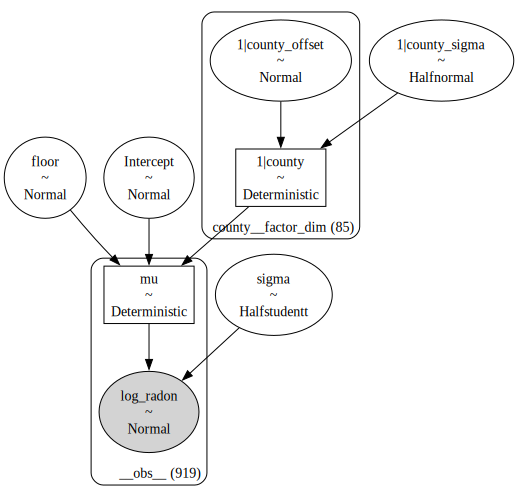

In [32]:
# Fit partial pooling (multilevel) model: varying intercept per county
partial_pooling_model = bmb.Model("log_radon ~ floor + (1|county)", data=radon)

partial_pooling_model.build()

partial_pooling_model.graph()

In [33]:
partial_pooling_results = partial_pooling_model.fit(idata_kwargs=dict(log_likelihood=True))

partial_pooling_results

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

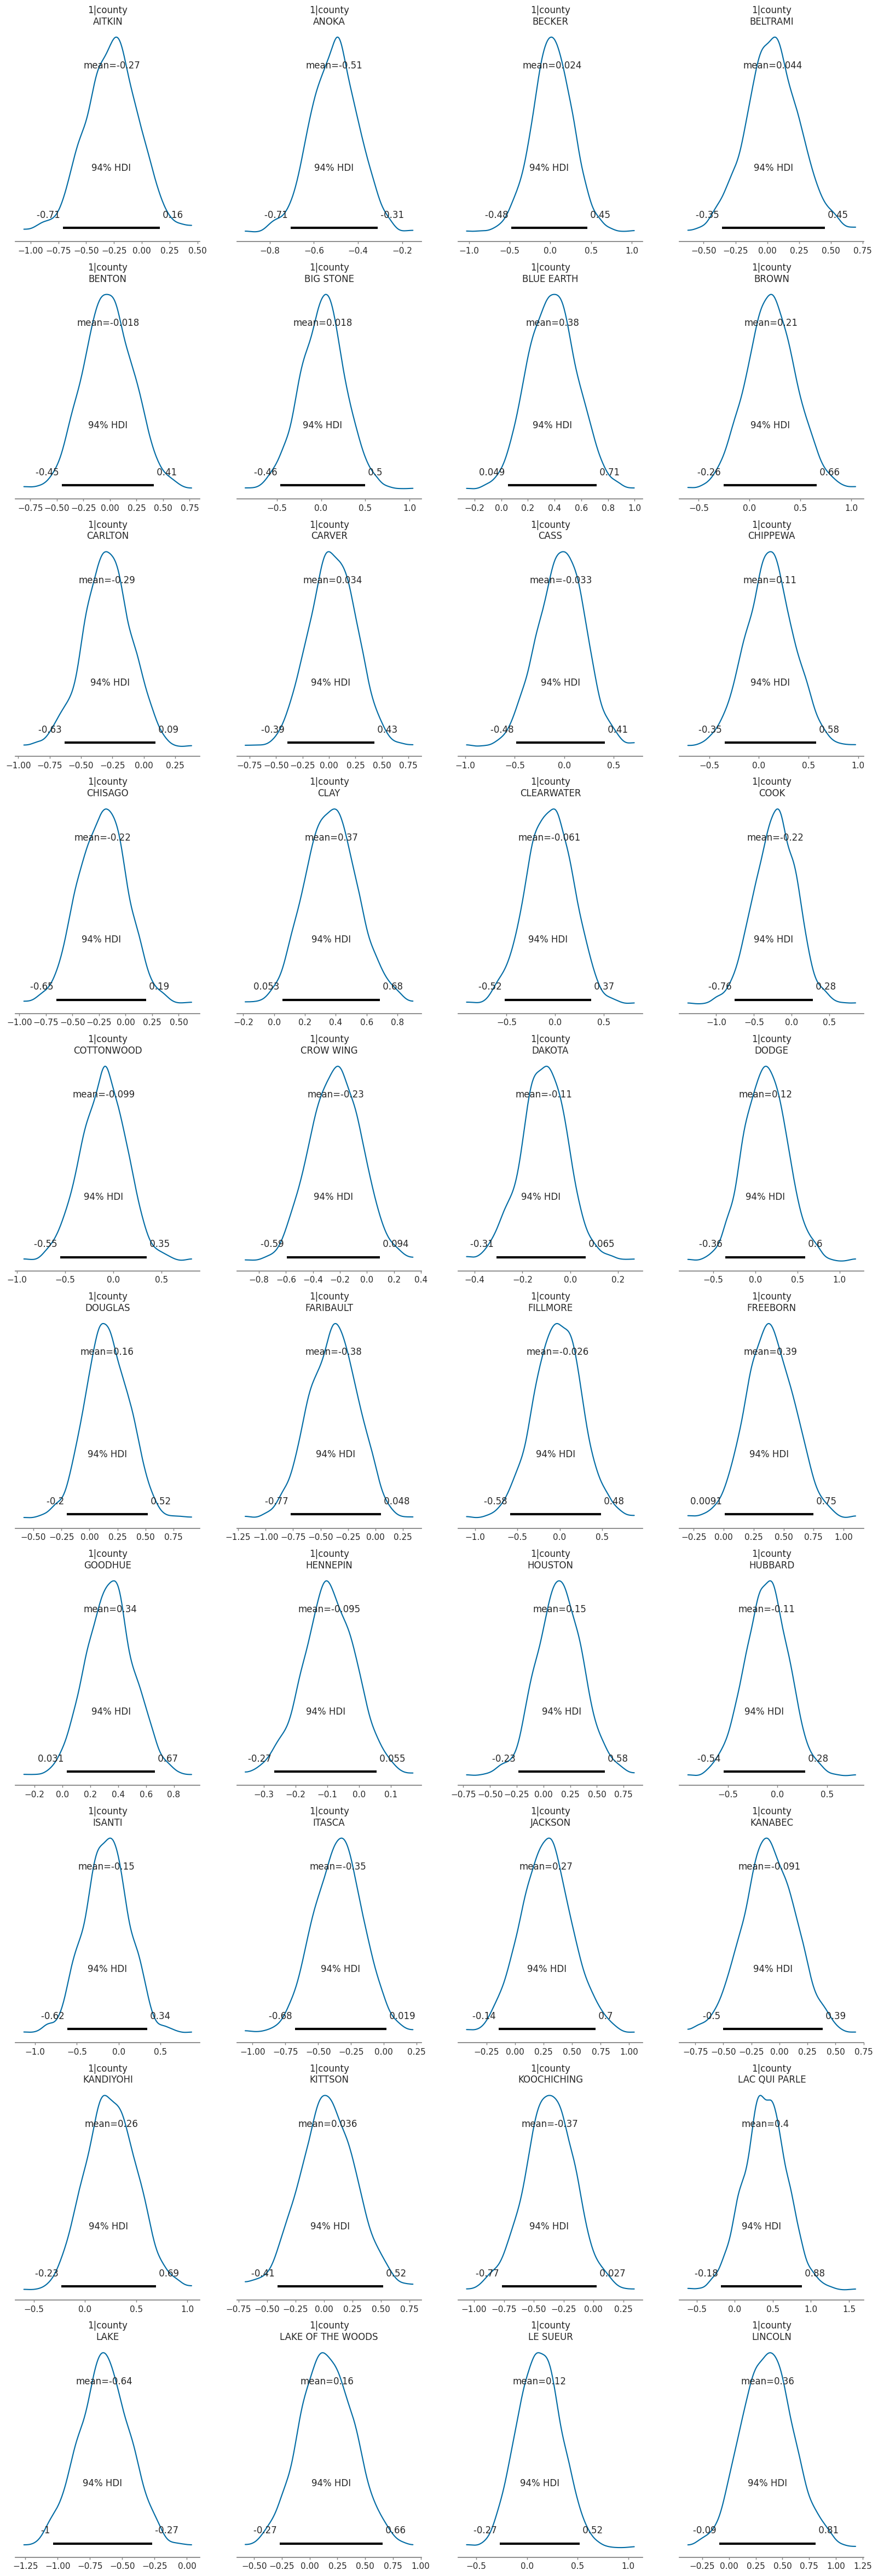

In [ ]:
az.plot_posterior(partial_pooling_results, figsize=(20, 60));

In [ ]:
az.summary(partial_pooling_results).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|county[AITKIN]          -0.27  0.24   -0.71     0.16       0.00     0.00   
1|county[ANOKA]           -0.51  0.11   -0.71    -0.31       0.00     0.00   
1|county[BECKER]           0.02  0.25   -0.48     0.46       0.00     0.01   
1|county[BELTRAMI]         0.04  0.21   -0.36     0.45       0.00     0.00   
1|county[BENTON]          -0.02  0.24   -0.45     0.41       0.00     0.00   
...                         ...   ...     ...      ...        ...      ...   
1|county[YELLOW MEDICINE] -0.08  0.26   -0.60     0.39       0.01     0.01   
1|county_sigma             0.32  0.04    0.25     0.40       0.00     0.00   
Intercept                  1.49  0.05    1.40     1.58       0.00     0.00   
floor                     -0.66  0.07   -0.78    -0.53       0.00     0.00   
sigma                      0.73  0.02    0.69     0.76       0.00     0.00   

                           ess_bulk  ess_tail  r_hat  
1|county[AITKIN]             2053.0    1607.0    1.0  
1|county[ANOKA]              2050.0    1393.0    1.0  
1|county[BECKER]             2159.0    1267.0    1.0  
1|county[BELTRAMI]           2122.0    1284.0    1.0  
1|county[BENTON]             2471.0    1432.0    1.0  
...                             ...       ...    ...  
1|county[YELLOW MEDICINE]    2222.0    1508.0    1.0  
1|county_sigma                674.0    1054.0    1.0  
Intercept                     989.0    1146.0    1.0  
floor                        1886.0    1358.0    1.0  
sigma                        1835.0    1291.0    1.0  

[89 rows x 9 columns]

In [ ]:
posterior_predictive = partial_pooling_model.predict(partial_pooling_results, kind="response")
partial_pooling_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

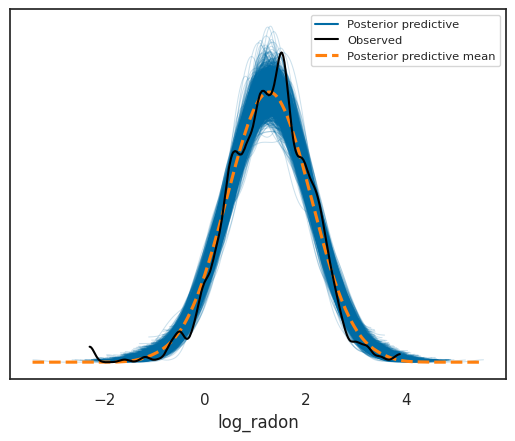

In [ ]:
az.plot_ppc(partial_pooling_results);

In [ ]:
loo_partial_pooled = az.loo(partial_pooling_results)
loo_partial_pooled

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1037.00    27.99
p_loo       49.29        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      918   99.9%
   (0.70, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    0    0.0%

---

## Reproduce Figure 12.4 from [Data Analysis Using Regression and Multilevel/Hierarchical Models](https://sites.stat.columbia.edu/gelman/arm/)

**Figure 12.4** Multilevel (partial pooling) regression lines $y = α_{j} + βx$ fit to radon data from Minnesota, displayed for eight counties. Light-colored dashed and solid lines show the complete-pooling and no-pooling estimates, respectively.

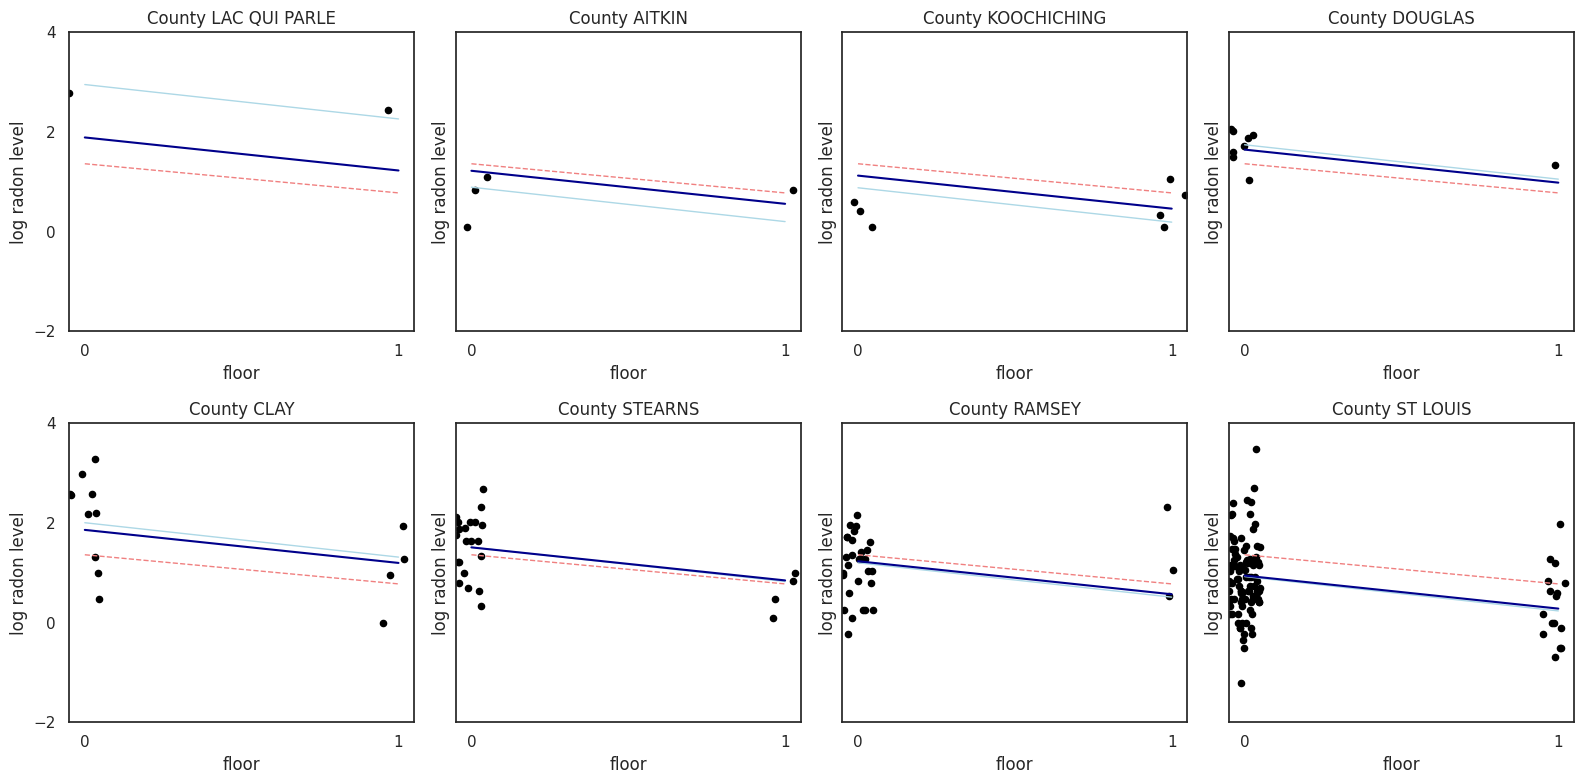

In [ ]:
# @title
# --- PREP DATA ---
x = radon["floor"].values
y = radon["log_radon"].values
county = radon["county"].values

# Jitter x slightly
np.random.seed(42)
x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))

# Counties to display
display8 = ['LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS']

# --- EXTRACT COEFFICIENTS ---
# Pooled model
pooled_summary = az.summary(pooled_results, kind="stats")
beta0_pooled = pooled_summary.loc["Intercept", "mean"]
beta1_pooled = pooled_summary.loc["floor", "mean"]

# Unpooled model
unpooled_summary = az.summary(unpooled_results, kind="stats")
slope_unpooled = unpooled_summary.loc["floor", "mean"]

# County-specific intercepts for unpooled model
county_intercepts = {}
for name in unpooled_summary.index:
    if name.startswith("C(county)["):
        county_name = name.split("[")[1].rstrip("]")
        county_intercepts[county_name] = unpooled_summary.loc[name, "mean"]

# Partial pooling model
partial_summary = az.summary(partial_pooling_results, kind="stats")
slope_partial = partial_summary.loc["floor", "mean"]
mu_a = partial_summary.loc["Intercept", "mean"]

# Random intercepts per county for partial pooling
partial_county_intercepts = {}
for name in partial_summary.index:
    if name.startswith("1|county["):
        county_name = name.split("[")[1].rstrip("]")
        partial_county_intercepts[county_name] = partial_summary.loc[name, "mean"]

# Add global intercept to each county for total fitted line
partial_estimates = {c: mu_a + partial_county_intercepts.get(c, 0.0) for c in display8}

# Determine y-limits
y_range = [np.min(y[np.isin(county, display8)]), np.max(y[np.isin(county, display8)])]

# --- PLOTTING 2x4 GRID ---
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)
axes = axes.flatten()

for idx, county_name in enumerate(display8):
    ax = axes[idx]

    # Scatter points
    mask = county == county_name
    ax.scatter(x_jitter[mask], y[mask], s=20, color="black")

    # Axes
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(y_range)
    ax.set_xticks([0, 1])
    ax.set_yticks(np.arange(np.floor(y_range[0]), np.ceil(y_range[1])+1, 2))
    ax.set_xlabel("floor")
    ax.set_ylabel("log radon level")

    x_vals = np.array([0, 1])

    # Pooled line: light-colored dashed
    y_vals_pooled = beta0_pooled + beta1_pooled * x_vals
    ax.plot(x_vals, y_vals_pooled, linestyle='--', color='lightcoral', linewidth=1)

    # No pooling line: light-colored solid
    intercept_j = county_intercepts.get(county_name, 0.0)
    y_vals_unpooled = intercept_j + slope_unpooled * x_vals
    ax.plot(x_vals, y_vals_unpooled, linestyle='-', color='lightblue', linewidth=1)

    # Partial pooling line: dark-colored solid
    y_vals_partial = partial_estimates.get(county_name, mu_a) + slope_partial * x_vals
    ax.plot(x_vals, y_vals_partial, linestyle='-', color='darkblue', linewidth=1.5)

    ax.set_title(f"County {county_name}")

plt.tight_layout()
plt.show()

---

# Compare models

In [ ]:
compare_dict = {"Model 1": loo_pooled,
                "Model 2": loo_unpooled,
                "Model 3": loo_partial_pooled}

az.compare(compare_dict).round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se    dse  warning scale
Model 3     0  -1037.00  49.29       0.00    0.92  27.99   0.00     True   log
Model 2     1  -1064.42  88.55      27.42    0.00  28.65   6.37     True   log
Model 1     2  -1089.78   3.63      52.78    0.08  24.99  10.77    False   log

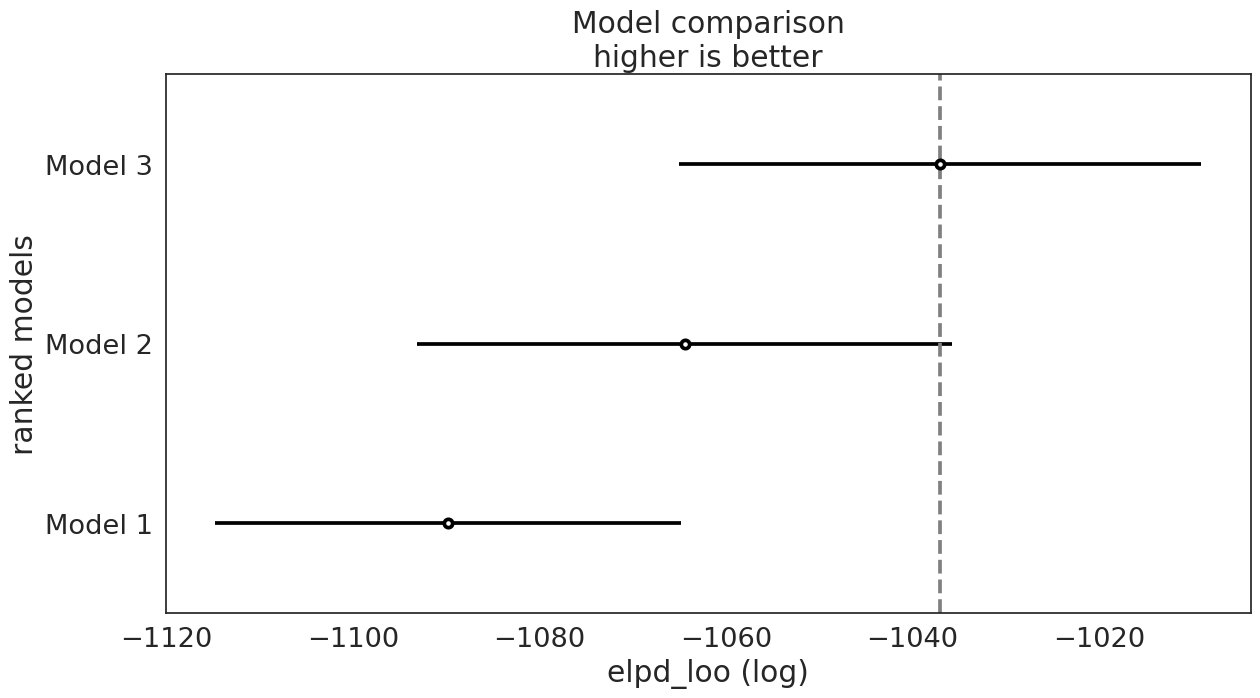

In [ ]:
az.plot_compare(az.compare(compare_dict), figsize=(14, 7));